Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [2]:
# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/5_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 10% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [3]:
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all") #and (name PO4 or name GM5)")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [71]:
# Leaflet separation

sel_tot = "all and (name PO4 or name GM5)"

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM5')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 4840
number of lipids in the upper leaflet: 2420 + number of lipids in the lower leaflet:2420 
= 4840


In [72]:
time_simu = 10 # microseconds
nb_frames_simu = 10000

In [73]:
def modulo(x,a,b):
    if x < a:
        x = x + (b-a)
    elif x >= b:
        x = x - (b-a)
    return x

In [440]:
tmes = 5
t_start = 8000

N = 15 # set the number of boxes into which will be divided the membrane
x_center_b = int(np.floor(N/2))
y_center_b = int(np.floor(N/2))

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

# r and theta pie parameters
nb_r = 15
nb_theta = 20 # need to be even in this case

lq = int(np.floor(nb_theta/2))+1
q = np.arange(nb_theta/2+1) # Fourier index
r_q_pow_list = [[] for r in range(lq)]

R_mean_list = [] # mean radius of the domain

stat = 0

time = []

frame_stack = 0
max_frame_stack = 5 # number of frames where the lipids are summed in the boxes

In [427]:
for ts in u.trajectory:

    if (ts.frame%tmes == 0 and ts.frame>=t_start):
        
        frame_stack += 1
        print('frame_stack = %d' %frame_stack)
        
        print(ts.frame)
        time.append(ts.frame/ (nb_frames_simu/time_simu))

        #determine the min and the max values of the box -------------------------------------------------------
        sel_all = "all and (name PO4 or name GM5)"
        patch = u.select_atoms(sel_all).positions

        xmax = max(patch[:,0])
        ymax = max(patch[:,1])

        xmin = min(patch[:,0])
        ymin = min(patch[:,1])
        
        #select the lipids of the different phases, Lo or Ld ----------------------------------------------------      
        sel_Lo = "all and (name PO4 and resname DPPC)"
        M_Lo = leaflet1.select_atoms(sel_Lo).positions
        M_Lo[:,2] = 1

        sel_Ld = "all and (name PO4 and resname DIPC)"
        M_Ld = leaflet1.select_atoms(sel_Ld).positions
        M_Ld[:,2] = 0

        M_coords = np.concatenate((M_Lo, M_Ld), axis = 0)
        
        # set the spatial x and y step to divide the membrane --------------------------------------------------
        dx = (xmax-xmin)/N
        dy = (ymax-ymin)/N
        
        # leaflet 1
        # divide the leaflet into a grid and calculate the concentration ratio in each box

        bary1 = []

        Mphi1_Lo = np.zeros((N,N))

        for i in range(0,N):
            xs = xmin + i*dx
            for j in range(0,N):
                ys = ymin + j*dy

                # barycenter of all molecules in each box
                sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                b1=leaflet1.select_atoms(sel).centroid().tolist()
                bary1.append(b1)

                # composition rates in each box
                sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                tot1PC= leaflet1.select_atoms(sel_totPC).positions
                n_tot1PC=len(tot1PC) # total number of PC

                sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                Lo1= leaflet1.select_atoms(sel_Lo).positions
                n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DIPC"
                Ld1= leaflet1.select_atoms(sel_Ld).positions
                n_Ld1=len(Ld1) # number of molecules of the Ld phase (DIPC here)

                if  n_tot1PC!=0:
                    phi1_Lo=n_Lo1/n_tot1PC
                else :
                    print('leaflet 1, empty box: i=%d and j=%d' % (i,j))

                Mphi1_Lo[i,j]=phi1_Lo

        bary1=np.array(bary1)
        
        # lower leaflet binary composition -------------------------------------------------------------------------
        Mphi1_bin = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_Lo[i,j]>= threshold :
                    Mphi1_bin[i,j]=1

        # find the domain larger axis ------------------------------------------------------------------------------
        M_sum = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                M_sum[i,j] = sum(Mphi1_bin[i,:])+sum(Mphi1_bin[:,j])
        val_max = 0
        x_big = 0
        y_big = 0
        for i in range(N):
            for j in range(N):
                if M_sum[i,j]>val_max:
                    val_max = M_sum[i,j]
                    x_big = i
                    y_big = j
        
        # reunify and center the Lo domain -------------------------------------------------------------------------
        vec_cor_b = np.zeros((1,2)) # vector containing the correction to apply to center
        x_cor = x_big - x_center_b
        y_cor = y_big - y_center_b
        
        M_full = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_bin[i,j]==1:
                    M_full[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = Mphi1_bin[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        # discard the isolated Lo boxes
        for i in range(N):
            for j in range(N):
                if (M_full[modulo(i-1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i-1,0,N),j]==0 and M_full[modulo(i-1,0,N),modulo(j+1,0,N)]==0 and M_full[i,modulo(j-1,0,N)]==0 and M_full[i,modulo(j+1,0,N)]==0 and M_full[modulo(i+1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i+1,0,N),j]==0 and M_full[modulo(i+1,0,N),modulo(j+1,0,N)]==0):
                    M_full[i,j] = 0
        
        # determine the barycenter of the domain and its width ----------------------------------------------------------------
        nb_Lo = int(np.sum(M_full))

        coords_Lo = np.zeros((nb_Lo,2))
        l = 0
        # domain barycenter
        for i in range(N):
            for j in range(N):
                if M_full[i,j] == 1 :
                    coords_Lo[l][0] = i
                    coords_Lo[l][1] = j
                    l += 1

        box_x_mean = np.mean(coords_Lo[:,0])
        box_y_mean = np.mean(coords_Lo[:,1])
        
        # domain width
        box_x_max = 0
        box_y_max = 0
# à voir comment on fixe r_max !!! si doit être cst ou non
        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1 and np.abs(i-box_x_mean) > box_x_max:
                    box_x_max = np.abs(i-box_x_mean)
                if M_full[i,j]==1 and np.abs(j-box_y_mean) > box_y_max:
                    box_y_max = np.abs(j-box_y_mean)
        box_max = np.ceil(max(box_x_max,box_y_max))
        
        x_mean_b = int(round(box_x_mean))
        y_mean_b = int(round(box_y_mean))
        
        # second correction to recenter the domain -----------------------------------------------------------------
        x_cor = x_mean_b - x_center_b
        y_cor = y_mean_b - y_center_b

        M_center = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1:
                    M_center[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = M_full[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        # convert the values in real space units -----------------------------------------------------------------------
        x_center = (xmin+xmax)/2
        y_center = (ymin+ymax)/2
        #r_max = box_max /N * (ymax-ymin) *1.1 # factor to be sure to get the boundary
        
        r_max = np.floor((xmax-xmin)/2)*0.9
        
        vec_cor = vec_cor_b /N * (ymax-ymin)
        
        # center the domain applying the total correction on the lipids --------------------------------------------
        for i in range(len(M_coords)):
            M_coords[i,0] = modulo(M_coords[i,0] - vec_cor[0,0],xmin,xmax)
            M_coords[i,1] = modulo(M_coords[i,1] - vec_cor[0,1],ymin,ymax)
                    
        dr = int(r_max/nb_r)
        dtheta = 2*np.pi/nb_theta
        
        # divide the leaflet into a pie
        if r_max < np.floor((xmax-xmin)/2)+dr: # condition à voir----------------------------------------------------
            
            x = M_coords[:,0]
            y = M_coords[:,1]
            print('done')
            stat += 1
            
            x_pie_r = [[] for r in range(nb_r)]
            y_pie_r = [[] for r in range(nb_r)]
            pie_r = [[] for r in range(nb_r)]

            x_pie_theta = [[] for t in range(nb_theta)]
            y_pie_theta = [[] for t in range(nb_theta)]
            pie_theta = [[] for t in range(nb_theta)]

            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords)):
                    xi = M_coords[i,0]
                    yi = M_coords[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r[r] = x_r
                y_pie_r[r] = y_r
                pie_r[r] = i_r

            for i in range(len(M_coords)):
                xi = M_coords[i,0]
                yi = M_coords[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta[t].append(xi)
                y_pie_theta[t].append(yi)
                pie_theta[t].append(i)
            
            
            # divide the leaflet into a pie - Lo lipids only
            l_Lo = int(np.sum(M_coords[:,2]))
            M_coords_Lo = np.zeros((l_Lo,3))

            j = 0
            for i in range(len(M_coords)):
                if M_coords[i,2] == 1:
                    M_coords_Lo[j] = M_coords[i]
                    j+=1

            x_Lo = M_coords_Lo[:,0]
            y_Lo = M_coords_Lo[:,1]

            x_pie_r_Lo = [[] for r in range(nb_r)]
            y_pie_r_Lo = [[] for r in range(nb_r)]
            pie_r_Lo = [[] for r in range(nb_r)]

            x_pie_theta_Lo = [[] for t in range(nb_theta)]
            y_pie_theta_Lo = [[] for t in range(nb_theta)]
            pie_theta_Lo = [[] for t in range(nb_theta)]


            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords_Lo)):

                    xi = M_coords_Lo[i,0]
                    yi = M_coords_Lo[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r_Lo[r] = x_r
                y_pie_r_Lo[r] = y_r
                pie_r_Lo[r] = i_r

            for i in range(len(M_coords_Lo)):
                xi = M_coords_Lo[i,0]
                yi = M_coords_Lo[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta_Lo[t].append(xi)
                y_pie_theta_Lo[t].append(yi)
                pie_theta_Lo[t].append(i)
                    
            
            # if we have already summed max_frame_stack frames, the pies are reset
            if (ts.frame == t_start or frame_stack > max_frame_stack) :
                # create and fill in the pie r, theta -------------------------------------------------------
                pie = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                print('RESET')
                
            print(pie[:5])
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r[r])):
                        if (pie_r[r][l] in pie_theta[t]):
                            pie[r][t].append(pie_r[r][l])

                # create the and fill in the pie r, theta -------------------------------------------------------
                if (ts.frame == t_start or frame_stack > max_frame_stack) :
                    
                    frame_stack = 0
                    
                    pie_Lo = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r_Lo[r])):
                        if (pie_r_Lo[r][l] in pie_theta_Lo[t]):
                            pie_Lo[r][t].append(pie_r_Lo[r][l])
            
            print('longueur : %d' %len(pie[2][0]))
            
#-----------if enough frames have been summed
                
            if (frame_stack == max_frame_stack) :

                # binarisation of the pie -------------------------------------------------------------------------
                M_pie_bin = np.zeros((nb_r, nb_theta))

                for r in range(nb_r):
                    for t in range(nb_theta):
                        if r==0:
                            M_pie_bin[r,t]=1
                        elif(len(pie_Lo[r][t])/len(pie[r][t])>=threshold):
                            M_pie_bin[r,t]=1
                                
                # determination of the Lo-Ld boundary --------------------------------------------------------------
                boundary = [[],[]]

                for t in range(nb_theta):
                    boundary[0].append(t)
                    b_found = 0
                    for r in range(0,nb_r-2,1):

                        if M_pie_bin[r,t]==1 and (M_pie_bin[r+1,t]==0 or r+1>=nb_r) and (M_pie_bin[r+2,t]==0 or r+2>=nb_r):
                            b_found = 1
                            boundary[1].append(r)
                    if b_found == 0:
                        if M_pie_bin[nb_r-2,t]==1 and M_pie_bin[nb_r-1,t]!=1:
                            boundary[1].append(nb_r-2)
                        elif M_pie_bin[nb_r-1,t]==1:
                            boundary[1].append(nb_r-1)

                theta_l = np.array(boundary[0])
                r_theta = np.array(boundary[1])
                R_mean_list.append(np.mean(r_theta))
                print(r_theta)

                # Fourier Transform of the boundary : r = f(theta) --------------------------------------------------
                r_q = np.fft.rfft(r_theta)
                r_q_pow = abs(r_q)**2

                print('stat = %d' %stat)
                for i in range(lq):
                    r_q_pow_list[i].append(r_q_pow[i])


frame_stack = 1
8000
done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8005
done
[[[], [671], [], [], [], [], [], [], [145], [], [], [203], [], [], [], [], [528], [], [], []], [[143, 778], [], [807], [566], [], [457, 714], [639], [], [95], [501], [], [68, 600], [754], [74], [815], [], [32], [188, 423], [477, 642], []], [[80, 101], [447, 538], [103, 147], [213], [69, 285, 449], [793], [803], [216, 405], [471], [176, 1446], [354], [], [390, 431], [310, 694], [612], [302], [30], [266, 523], [372, 749], [82]], [[554], [81, 333, 816], [154], [92, 241, 766], [189, 215, 643], [228, 794], [300], [165

done
[[[145, 671], [671], [671, 566], [566, 449, 671], [], [], [145, 566], [145, 639], [145, 95], [], [203], [203, 203], [95, 145], [], [528], [528, 188], [528, 528, 143], [188, 188], [], [671, 807]], [[143, 778, 143, 143, 778, 778], [778, 807, 807, 538], [807, 807, 449, 103], [566, 449], [449, 566, 457, 457, 213], [457, 714, 457, 714, 714], [639, 639, 405, 714, 457, 714], [95, 216, 639, 216, 405], [95, 216, 639], [501, 501, 600, 95, 216], [600, 354, 501], [68, 600, 600, 600], [754, 74, 68], [74, 74, 694, 68, 203, 528], [815, 612, 815, 612], [32, 815, 74, 188], [32, 423], [188, 423, 423, 523, 423, 642], [477, 642, 372, 372, 642, 477], [477, 642, 143, 642]], [[80, 101, 80, 80, 778, 80, 80, 81], [447, 538, 538, 538, 81, 147, 538, 147, 447], [103, 147, 103, 147, 147, 103, 154], [213, 213, 103, 213, 285, 213, 285, 241, 285, 766], [69, 285, 449, 69, 69, 69], [793, 69, 189, 228, 793, 189], [803, 228, 793, 793, 405, 803, 228, 793], [216, 405, 405, 553, 553, 553, 803], [471, 471, 176, 471, 471

done
[[[], [778, 143], [671], [566], [566], [457, 145], [], [457, 671], [639], [145], [203], [671], [145, 68, 528], [528], [145, 528, 528], [815], [188, 671], [], [143, 188, 423], [143]], [[778, 477, 477, 642], [807, 143, 778, 477], [449, 449, 807, 778], [213, 449], [69, 213, 69, 566, 449], [793, 69, 793, 566], [714, 793, 457, 714, 69], [803], [216, 714, 216, 639, 457], [95, 639, 501, 95, 639], [600, 95, 95], [600, 600, 203], [203, 74, 203], [74, 612, 74, 68, 612], [612], [815, 815, 32, 612], [188, 815, 188], [423, 423, 523, 523, 523], [642], [642, 423, 642]], [[80, 538, 80, 82, 809], [147, 81, 538, 538, 80, 81, 82], [103, 241, 147, 447, 807, 333, 538], [285, 103, 241, 103, 241, 147, 807], [189, 215, 285, 213, 285, 103, 154], [405, 189, 228, 189, 189, 213, 228, 285, 793], [300, 794, 300, 405, 405], [300, 405, 803, 300, 714], [553, 553, 803, 553, 803], [471, 501, 216, 471, 176, 471, 216], [100, 100, 501, 100, 100, 501], [741, 55, 741, 600], [68, 68, 754, 354, 74, 354], [694, 754, 608, 6

done
[[[], [], [143], [], [], [671], [145], [], [], [145], [], [], [203], [528], [815], [143, 423], [642], [], [188], [477, 423]], [[82, 340, 82], [477], [538, 778], [807, 671], [566], [449, 566], [213, 457], [457], [639], [639, 95], [95, 600], [203, 74], [74], [528, 612], [188], [302, 523], [302], [372, 690, 523], [372], [642]], [[809, 749], [81, 383, 340], [80, 333, 538, 778], [147, 154, 807], [103, 241, 449], [189, 285, 213], [69, 69, 793], [405, 793, 405, 714], [714, 803, 471], [216, 471, 216, 501], [501, 390], [100, 600, 100, 354, 741], [694, 68, 694, 754], [68, 608, 612, 266, 608], [32, 815, 32, 584], [362, 42, 362], [42, 205, 690], [286, 127, 205, 484], [334, 569, 749, 286], [107, 569]], [[277, 505, 107, 575], [554, 383, 809], [327, 579, 81, 333, 554], [434, 447, 147, 327], [766, 103, 154, 215, 241], [215, 228, 643, 683, 228, 285, 683], [43, 189, 794], [300, 564, 794, 300, 564, 803], [211, 553, 211], [165, 176, 594], [176, 2081], [390, 741, 55], [55, 769, 282, 310, 769], [354, 7

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
8095
done
[[[423], [], [], [], [], [], [], [145], [], [203, 528], [], [], [600], [], [], [], [], [188], [], []], [[642, 749], [], [82, 143], [566, 671], [457], [639], [], [216], [95], [], [74], [68], [], [608, 612], [], [32, 815], [], [42, 302], [], [523]], [[809], [340], [538], [477], [69, 213], [714, 793], [471, 794], [803], [176, 211, 564], [553], [390, 501], [100, 165], [55, 694], [754], [266, 584, 664], [162, 362], [30], [483, 484], [286, 372, 690], [569]], [[101, 575, 682], [107, 383, 579], [81], [449, 778, 807], [103, 189, 285], [228, 6

done
[[[423, 423], [423, 423], [143], [143], [143], [], [528, 528], [145, 145, 528, 145], [528], [203, 528, 423], [188], [188], [600, 188, 815, 188], [815], [], [302, 302], [523], [188], [523], [523]], [[642, 749, 372, 749, 642], [642, 749, 642], [82, 143, 82, 82, 82], [566, 671, 82], [457, 566, 671, 143, 477], [639, 671, 671, 671], [457, 457, 639], [216, 145, 639, 639, 639], [95, 203, 216, 203, 216, 145, 203], [74, 176, 176, 203], [74, 74, 95, 95, 74], [68, 600, 100, 600, 600], [815], [608, 612, 612, 612, 612], [612, 815, 32, 302], [32, 815, 32, 362, 32, 32], [42, 42, 302, 42], [42, 302, 42, 690, 690, 690, 690], [523, 372, 618], [523, 286, 642, 286, 372]], [[809, 569, 286, 569, 286, 569, 809, 334, 569, 575], [340, 809, 340, 749, 809, 340, 809], [538, 340, 538, 538, 538, 340, 383, 749], [477, 477, 477, 566, 477, 538], [69, 213, 449, 213, 449, 449, 566, 449, 778], [714, 793, 189, 213, 285, 714, 213, 566], [471, 794, 69, 793, 471, 457, 714, 213, 457], [803, 471, 714, 471, 471, 803], [176

done
[[[203, 639, 145], [639], [], [639, 639], [], [471, 471], [216], [216, 216], [176], [176, 216], [], [95], [95, 203], [95], [], [203], [203, 528], [], [528], [528]], [[143, 143, 145, 143], [145, 145, 538], [457, 671, 671, 477, 671, 671], [471, 457, 457, 457, 477], [405, 471], [803, 405, 405], [1404], [803, 803, 1404], [564, 564, 564, 564, 803], [553, 553], [211, 553, 501, 176, 176], [501, 165, 165, 501], [74, 100, 95], [68, 100, 165], [100, 68, 74], [600, 600, 74, 612], [74, 612, 600, 600], [188, 815], [528, 815, 188, 188], [523, 143, 423]], [[642, 82, 82, 642], [538, 538, 538, 778, 82], [477, 566, 477, 566, 566], [213, 213, 213, 213, 566], [714, 762, 714, 794, 189, 714, 189, 714], [364, 794, 405, 762, 762, 793], [48, 1404, 355, 762], [258, 2406, 17, 2406, 17, 1404], [300, 300, 48, 2406, 48], [51, 644, 211, 644, 211, 300], [49, 469, 594, 594, 211, 594, 49, 553], [422, 422, 764, 501, 594], [55, 165, 55, 55, 55, 422], [117, 694, 694, 117, 694, 100], [608, 310, 354, 608, 68, 68, 608],

done
[[[], [528], [145], [], [639], [671], [471], [], [639, 203], [], [], [74], [528], [], [600], [], [815], [], [188, 188], []], [[642], [145, 423], [], [538, 671], [477, 457], [471, 216], [], [216], [], [203, 95, 501], [], [74, 165, 165], [612, 68, 612], [], [266, 266, 600], [], [302, 815], [302], [286, 372, 372], [143, 143]], [[81, 340, 642, 81, 340], [82, 423, 778, 82, 778], [566, 538, 566], [213, 213, 477], [53, 714, 714, 794], [364, 457, 53, 364], [405, 405, 762], [803, 211, 803], [95, 176, 176, 553, 594], [55, 422, 501, 55, 422], [117, 117, 601], [100, 741, 100], [68, 310, 754], [694, 354, 694], [32, 584, 608, 584, 608], [402, 32, 362], [362, 483, 690], [618, 690, 42], [42, 127, 286], [523, 569, 523, 749]], [[708, 749, 78], [78, 333, 333], [103, 449, 434, 449], [189, 103, 189, 285], [69, 643, 793, 794, 643], [228, 585, 228, 411, 793], [762, 43, 585], [553, 1404, 564, 1404, 2406], [211, 594, 48, 258], [644, 764, 644], [390, 601], [2081, 741, 2081], [754, 431], [0, 354, 572, 769, 

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8185
done
[[[], [], [639], [], [], [], [], [], [], [], [], [], [], [], [203, 815], [], [], [], [528], []], [[], [145], [477, 671], [], [457, 471], [], [216], [553], [176], [95, 594], [501], [74], [], [612], [], [32], [188], [], [372], []], [[81, 423], [82, 213, 538], [714], [53, 794], [364], [405], [803, 1404, 2406], [211], [564], [], [55, 644], [422, 741], [165], [68], [266, 600], [401, 402, 608], [362], [42, 302, 523], [], [143]], [[78, 340], [434, 566, 778], [103, 285], [189, 411, 643], [228, 479, 755], [585, 619, 793], [762], [43, 51, 789,

done
[[[671], [671, 671], [639, 639], [471], [471, 639, 471], [], [], [95], [95], [], [95, 203], [203], [203, 203], [], [203, 815, 528, 528], [], [639, 528], [528], [528, 639, 145], [671]], [[538, 143, 145, 423], [145, 213, 538, 538], [477, 671, 477, 714], [457, 477, 477, 477], [457, 471, 216, 471, 457], [216, 216, 216, 405], [216, 176, 176, 803, 176, 803, 803], [553, 803, 176], [176, 553, 553, 553], [95, 594, 594, 564, 594, 95, 564], [501, 594, 501], [74, 501, 501, 422, 501], [612, 74, 422], [612, 74, 74, 266, 74, 266], [815, 815, 402, 266], [32, 402, 815, 402, 815], [188, 32, 32, 32], [188, 372, 188, 188, 145, 188], [372, 372, 372, 372], [145, 423, 143, 143, 523]], [[81, 423, 82, 778, 81, 81, 423], [82, 213, 538, 566, 82, 538, 82, 82], [714, 103, 213, 103, 213, 103, 213], [53, 794, 457, 714, 794, 714, 714, 794, 53, 794], [364, 53, 364, 794, 53, 457, 364], [405, 405, 793, 364, 405, 364, 405, 1404, 793], [803, 1404, 2406, 1404, 1404, 43, 1404, 2406], [211, 2406, 2406, 43, 553], [564, 2

done
[[[78, 145], [], [639, 671], [671], [471], [81, 423, 639], [], [203, 639, 203], [], [501], [143], [203], [74, 523, 74], [815], [815], [528], [528], [], [], [145, 528, 809]], [[143, 277, 523], [671, 423, 538, 143], [538, 154, 333, 778, 423, 538], [477, 477], [457, 566, 457, 477], [405, 471, 405], [103, 471], [176, 553, 176, 216, 82, 95], [95, 538], [95, 594, 671, 562], [501, 501], [422, 145, 422], [74, 422], [266, 608, 188, 642], [584, 402, 372, 402, 608], [402, 127, 286, 340, 584], [32, 749, 32], [32, 188, 145, 188, 134], [708, 815], [523, 143, 523, 107, 188, 372]], [[81, 423, 78, 81, 93, 696, 78, 642, 809], [82, 103, 778, 101, 140, 81], [213, 82, 383, 807, 103], [714, 794, 213, 147, 447, 82, 213], [364, 53, 714, 794, 449, 53, 714], [1404, 364, 457, 285, 405, 1404], [211, 216, 1404, 189, 213, 176, 216], [477, 714, 553, 564], [562, 564, 211, 553, 457, 594], [594, 95, 639, 469, 644], [55, 165, 165, 562, 528, 165], [601, 612, 741, 68, 612, 74, 815, 601, 612], [68, 600, 600, 32, 584, 

done
[[[103], [642], [82], [523], [], [], [], [], [], [145, 213, 457], [815], [], [32], [], [538], [], [188], [], [143], []], [[340, 154], [809], [81, 778, 147, 566], [285], [143, 189], [103, 671], [538, 714, 794], [471, 639, 53], [405], [528, 216], [402, 477], [471], [584, 639], [401, 528], [302], [362, 671], [523], [42, 81], [286, 372], [334, 423]], [[127, 682, 333, 383], [78, 277, 447], [449], [154, 566, 241, 434], [82, 423, 643, 680], [213, 69], [457, 477, 364, 683], [176, 2406], [95, 48, 553, 1404], [211], [74, 203, 176], [600, 608, 95, 501], [354, 572], [184, 704, 203], [108, 664, 32, 145, 402], [815], [205, 618, 188, 642], [340], [121, 279, 569, 778, 809], [749, 805, 78, 277, 708]], [[93, 107, 80, 140], [101, 708, 22, 655, 807], [383, 139, 766], [147, 333, 449, 884], [285, 737], [189, 794, 411, 455], [53, 405, 714, 228], [216, 479, 793], [211, 594, 803, 808], [165, 501, 562, 51, 258], [422, 612, 594, 630], [266, 694, 754, 562, 564], [504, 769, 74, 165, 422, 600], [282, 684, 608]

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8275
done
[[[], [213], [], [], [], [714], [], [], [], [], [], [405], [], [457], [], [], [], [82], [], []], [[285], [], [], [69, 189, 683], [], [794], [], [53], [364], [216, 2406], [48], [176], [], [477], [203], [538], [671], [103, 423], [], [566]], [[434, 449], [241, 884], [342], [], [215, 680], [737], [228], [793, 1404], [762], [553], [51], [211, 594], [471], [], [32, 528], [145, 639], [523], [143, 642], [81, 778], [154]], [[807], [147], [447, 463, 602], [298, 533, 668], [191, 633, 643], [438], [411, 455, 755], [355, 479, 619], [803], [300, 8

done
[[[], [213], [566, 566, 145], [213], [], [714, 189], [189], [], [82, 639], [405], [82], [405, 538], [], [457, 103], [82, 538, 671, 32], [], [], [82, 401], [103, 815], [566, 423, 423]], [[285, 423, 449, 147], [241, 285, 143, 523], [285, 434, 69, 778], [69, 189, 683, 69, 884, 285, 884, 671], [683, 69, 683, 82, 103], [794, 189, 538], [794, 213, 714, 714, 457], [53, 213, 794], [364, 714, 1404, 176, 203], [216, 2406, 2406, 405, 457, 53, 471], [48, 53, 477, 405, 477, 95], [176, 216, 203, 457, 528], [457, 477, 203, 74, 422], [477, 145, 639, 538], [203, 639, 402, 584], [538, 671, 145, 671, 608], [671, 103, 523, 143, 523, 778, 572], [103, 423, 143, 188], [778, 154, 372], [566, 778, 449, 127, 642]], [[434, 449, 147, 449, 807, 383, 807, 383, 807, 340, 809], [241, 884, 434, 147, 139, 78, 81], [342, 241, 447, 241, 447, 154, 333], [342, 434, 884, 423, 449], [215, 680, 215, 298, 680, 683, 215, 298, 566], [737, 680, 737, 680, 213], [228, 228, 794, 533, 405], [793, 1404, 1404, 228, 737, 477], [762

done
[[[82], [216], [69], [213], [671], [216], [53], [145, 213], [], [639, 82], [32, 300], [], [405], [2406], [], [566], [584, 405], [], [815, 778, 300], []], [[143, 423, 285, 285], [285, 69], [154, 523, 683, 69], [680, 714], [566, 778, 215, 213, 714], [189, 794, 189], [103, 714, 794], [538, 53, 53, 479, 553], [203, 793, 1404, 793], [216, 300, 803], [422, 364, 803], [2406, 48, 48], [402, 528, 457, 2406, 364], [457], [1288, 103, 145, 538, 538], [608, 671, 103, 405, 538], [401, 572, 523, 523, 566], [143, 566, 778], [372, 642, 154, 82], [127, 333, 154, 423]], [[81, 809, 147, 449, 139, 147, 139, 147], [78, 139, 241, 434, 241, 434], [277, 333, 434, 680, 680, 683], [423, 342, 215, 683], [69, 298, 533, 737, 643, 737], [213, 643, 737, 189, 228, 619], [53, 82, 794, 479, 619, 411], [405, 457, 553, 1404, 355, 553, 789], [477, 762, 355, 1404], [176, 471, 122, 803, 122, 793, 122], [95, 501, 51, 364, 51, 211, 51, 562], [74, 48, 477, 211], [576, 457, 477, 471, 477, 501], [100, 565, 471, 95, 471], [75

done
[[[], [], [213], [405, 189], [], [], [364], [300], [538], [], [2406], [], [], [], [103], [], [82], [69], [778], []], [[523, 147], [423, 434], [285, 683], [69, 82, 714, 737], [300, 2406], [803, 228, 794], [216], [793], [457, 803], [477], [553, 793], [471, 501], [364], [203, 457], [405], [528, 584], [145, 566, 523], [32, 671, 449], [423], [285]], [[81, 154, 139, 277], [333, 449], [147, 680], [189, 213, 215], [455], [216, 619], [53, 411], [553, 53, 789], [51], [48, 176, 211, 1404], [165, 122], [694, 48, 51], [68, 95, 612, 477], [422, 471, 538], [402, 566], [100, 671, 778], [639, 815], [608, 81], [372, 815, 154], [127, 143, 333, 708]], [[78, 809, 807], [277, 708, 241], [139, 434, 342, 463, 884], [680, 683, 298, 533, 643], [714, 794, 191, 633], [737, 1404, 438, 522, 735], [479, 650, 755], [122, 808, 355], [562, 630, 43, 375, 479], [626, 762, 808], [28, 594, 986, 562, 630, 786], [764, 165, 176, 211], [310, 600, 501, 694], [74, 217, 363, 513, 95], [84, 565, 576, 103, 203], [75, 638, 1288

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8365
done
[[[], [], [], [538], [], [], [471], [], [48], [], [], [], [95], [], [], [], [103], [], [], [566]], [[], [523], [405], [423], [457], [364], [51], [477], [176], [], [694], [501], [], [203, 422], [], [100], [], [528], [], [145]], [[81, 778], [285], [69], [189, 2406], [793], [122, 803], [], [17, 786], [211, 630], [165, 594], [986], [68, 310, 764], [600], [74, 612], [402, 584], [513], [184, 754], [32, 815], [639], [372, 671]], [[127, 143, 286], [154, 302, 449], [147], [683], [82], [53, 479, 553], [1404], [762, 808], [562, 821], [626, 644]

done
[[[523, 449, 778], [523, 778], [], [538], [538], [538, 364], [471, 364, 364, 364], [], [48, 471], [471], [471, 471], [], [95], [538, 528, 528], [103, 103], [566], [103], [566, 103], [566, 103], [566]], [[523], [523, 449, 523], [405, 405, 423, 405, 405], [423, 457, 2406, 405, 2406, 538, 2406], [457, 803, 457, 457, 793], [364, 793, 793, 803, 1404], [51, 122, 793, 457], [477, 51, 477, 477, 211], [176, 477, 477], [176, 176, 176, 176], [694, 48, 48, 95, 48, 48, 501], [501, 95, 95, 203], [95, 203], [203, 422, 203, 203, 100], [100, 584, 528], [100, 528, 32, 100, 100, 566, 671], [145, 145], [528, 671, 815, 372], [671, 145, 143], [145, 778, 671, 778, 81, 81, 449]], [[81, 778, 81, 127, 340, 340, 127, 127], [285, 449, 127, 285, 423, 302, 423], [69, 69, 285, 423, 285, 285], [189, 2406, 189, 2406, 553, 69, 69], [793, 553, 553, 1404, 53, 553, 803], [122, 803, 479, 803, 1404, 479, 479], [630, 122, 630, 122, 51], [17, 786, 17, 786, 51, 17, 51, 630, 17, 630], [211, 630, 211, 211, 211, 562, 562], [

done
[[[457, 538, 778], [], [538], [538, 538], [], [], [364, 457, 51], [], [364, 457], [477, 364], [], [364], [471], [95, 103, 471], [], [103], [103], [471, 778], [81], []], [[449, 127, 449, 523], [405, 803, 523], [523, 2406], [553, 803, 803, 553], [553, 793, 803], [793, 51, 51, 793], [51, 457, 17], [211, 17, 211, 211, 562], [562, 562, 211, 562], [165, 176, 477, 176], [176, 48, 477, 477], [694, 95, 48, 95, 48], [48, 203, 471], [203, 528, 95, 203], [528], [528, 566, 671, 671, 671], [566, 778, 372, 143], [103, 778, 372, 143, 81], [81, 143], [523, 340, 505, 449]], [[127, 127, 809, 302, 809], [423, 285, 423, 423, 405, 423], [69, 2406, 405, 405, 683, 683], [479, 683, 683, 2406, 553, 2406, 479], [53, 479, 479, 793, 789], [122, 1404, 355, 1404, 355, 1404, 762, 1404], [355, 630, 17, 630, 355, 630], [17, 626, 560, 626, 630, 821, 560, 821], [560, 594, 594, 626, 626], [564, 165, 176, 564, 594, 594], [68, 165, 165, 694], [68, 310, 764, 501, 68, 310, 68], [501, 612, 612, 501, 501, 584], [422, 584, 

done
[[[], [449], [], [2406], [2406], [538], [], [], [211, 364], [], [], [], [457], [364], [778], [103, 81], [], [], [], []], [[523, 423], [405, 154, 523], [405], [189, 683, 69], [553], [803, 683], [793, 803], [51, 538], [562, 51], [211, 457], [477], [103, 471], [95], [471, 143], [566], [143, 372], [778], [81, 815], [127, 127, 340], [449, 42]], [[423, 107, 302], [154, 285], [69, 147, 434], [189], [53, 553], [479, 789, 479], [1404, 793], [17, 355, 355], [564, 594, 562], [165, 176, 477], [176, 626, 48], [48, 501, 95, 203], [203, 584, 100], [100, 671], [528, 671, 684], [145, 30, 145, 431], [372], [642, 815, 642], [340, 334, 505], [42, 809]], [[22, 107, 302, 22, 101], [285, 708], [147, 333, 434, 241, 333], [213, 327, 342, 139, 327, 342], [82, 216, 300, 53, 82, 300], [122, 411, 122, 789], [630, 762, 821, 1404], [560, 17, 88, 560], [410, 808, 564, 594], [644, 694, 165, 626], [68, 310, 68, 310], [422, 600, 601, 501, 612], [612, 576, 584], [402, 754, 32, 402, 528, 639], [184, 639, 184, 608], [

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8455
done
[[[], [], [], [107], [], [], [405], [], [], [523], [], [154], [], [423], [], [], [], [302], [], []], [[22, 807], [101], [708], [], [285], [139], [241], [147], [], [], [683], [449], [127], [42], [505], [334], [], [809], [], [554, 682]], [[80, 277], [459, 771], [78], [351, 412], [434, 602], [643], [766], [69, 333, 342], [82], [189, 2406], [538, 803], [], [778], [340, 815], [642], [286, 572], [460], [704, 790], [749], [136, 689]], [[38, 775], [383], [1, 447, 715], [92, 615], [533], [213, 298], [680], [327], [53, 789], [553, 1404], [793]

done
[[[538], [364], [2406, 189], [107, 189], [], [803], [405, 189, 803], [793], [803, 538], [523, 553, 477], [793, 793], [154, 793], [457, 457], [423, 457], [364], [81, 364], [143], [302, 364], [], [538, 449, 778]], [[22, 807, 523, 683, 449, 523, 683, 449], [101, 147, 147, 683, 683], [708, 69, 538], [2406, 189], [285, 82, 82, 803], [139, 762, 82, 82, 553, 789], [241, 762, 789], [147, 789, 1404, 553, 789, 479], [479, 553, 17], [479, 562, 562], [683, 355, 51, 562, 51], [449, 477, 477, 51], [127, 477, 103, 471, 471], [42, 51, 457], [505, 471, 103, 143, 103, 671], [334, 81, 103, 143, 143, 372, 145], [81, 372], [809, 778, 340, 778, 340, 642], [449, 127, 778, 81], [554, 682, 127, 127]], [[80, 277, 154, 405, 154, 154, 523, 423, 523], [459, 771, 241, 405, 69, 147, 241, 405, 405], [78, 139, 342, 69, 241, 342, 342, 69, 147], [351, 412, 333, 766, 333, 333, 342], [434, 602, 680, 327, 2406, 53, 122, 327, 53, 2406], [643, 327, 53, 122, 411, 762, 122, 762], [766, 43, 53, 122, 1404, 43, 630, 1404, 14

done
[[[], [538, 81, 81], [538], [803, 2406], [], [538], [553, 538], [793, 364, 364], [], [479, 364], [], [457], [457, 457], [778], [143, 143, 143, 778], [143], [], [778, 778], [364], []], [[683, 523, 523], [683], [683, 147, 449, 683], [189, 2406, 69, 189, 189, 189], [122, 2406, 122], [82, 803, 803, 53], [553, 789], [789, 553, 553, 803], [355, 479, 793, 479, 793], [562, 562, 793], [477, 51], [51, 477, 477, 471, 477], [457, 471, 671, 95], [103, 671, 103, 671], [671, 103, 103], [145, 145, 145, 145], [372, 815, 372], [372, 815, 372, 815, 815], [340, 340, 340, 340, 642], [81, 127, 449, 81, 449, 449]], [[423, 523, 127, 505, 147, 423], [147, 241, 147, 523, 241, 241], [69, 333, 342, 342, 69, 333], [766, 333, 766, 69, 766], [53, 327, 680, 2406, 680, 327, 680], [122, 53, 762, 327, 411, 762], [762, 1404, 82, 53, 82, 762, 82], [630, 355, 630, 355, 479], [258, 560, 17, 88, 258, 789, 17], [17, 88, 410, 562, 564], [564, 594, 564, 644, 51, 51, 626], [626, 211, 626, 211, 626, 211], [48, 211, 471, 48, 

done
[[[], [803], [81], [], [], [803], [538], [], [538], [], [2406], [], [364], [], [143], [], [143], [], [340], [340]], [[147, 683], [81, 241, 683, 241], [189], [189], [69, 69, 680], [], [122, 479], [479], [553, 2406], [], [793, 793], [457, 457], [103, 103, 364], [671, 778], [145, 778], [145], [372, 372], [642, 815], [642], [449, 523, 449, 523]], [[127, 147, 154, 154], [285, 342, 342], [333], [766, 139, 333, 766], [602, 602], [327, 680], [762, 122, 213, 327], [53, 82, 53, 762], [88, 562, 789, 82, 553, 789], [17, 17, 51, 562], [51, 564], [477, 471, 477], [528], [528, 584, 671], [184, 401, 184], [684, 34, 684], [566, 566], [30, 815, 30, 121], [42, 121, 42, 505], [505, 127]], [[423, 809, 423, 809], [78, 101, 459, 101, 285, 459], [405, 434, 708, 405, 708], [139, 533, 777], [114, 114, 533], [213, 411, 643, 216, 643], [300, 1404, 300, 411], [1040, 630, 1040], [355, 821, 355], [564, 594, 644, 88, 644], [211, 594], [48, 471, 48, 211, 501, 626], [95, 203, 576, 95, 203, 584], [639, 100, 422], [

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
8545
done
[[[], [538], [], [], [], [], [], [], [], [2406], [], [], [], [], [], [], [479], [], [], []], [[], [803], [], [122], [680], [53], [411, 1404], [82, 762], [], [88, 553, 793], [], [51], [364, 477], [], [457, 671], [145], [], [815], [143], [340, 642, 778]], [[449], [81], [189, 241, 766], [69], [], [213, 327], [300], [1040], [789], [], [17, 564], [211], [471, 528], [103], [584], [184, 401], [684], [372, 566], [30, 121], [42, 523]], [[127, 147, 154, 809], [683], [333, 342], [114, 139, 602], [298, 533, 643], [43, 216, 786], [399, 641], [260

done
[[[340], [538], [340, 803, 671], [803], [], [538, 2406], [479, 538], [2406, 364, 671], [], [2406, 364], [364, 477], [364], [671], [103], [815], [778], [479, 778, 815], [143, 778], [143, 479], [143, 778]], [[340, 449, 523, 340], [803, 449, 81, 803, 479], [803], [122, 189, 122, 189, 479, 538, 538], [680, 122], [53, 53, 53, 2406], [411, 1404, 411, 553, 762, 553], [82, 762, 82, 762, 762, 793, 793], [553, 82, 51], [88, 553, 793, 2406, 553, 51, 477, 471], [793], [51, 457, 477, 528, 528], [364, 477, 457, 103, 457, 457], [671, 103], [457, 671, 145, 815, 815, 184, 584], [145, 372, 145, 145, 184], [372, 145], [815, 30, 566, 642, 30, 143, 372], [143, 642, 30, 642, 642], [340, 642, 778, 523]], [[449, 523, 147, 42, 127, 523], [81, 81, 147, 683, 683, 81, 147, 449, 81, 449], [189, 241, 766, 241, 333, 241, 122, 122], [69, 766, 333, 766, 53, 189, 69, 241], [69, 602, 69, 69, 53], [213, 327, 680, 680, 411, 300, 411], [300, 300, 411, 327, 300, 762, 1040], [1040, 1404, 300, 1404, 82, 82], [789, 789, 7

done
[[[], [479], [], [778], [778, 479], [815], [364], [671], [103, 364], [477], [], [], [184, 184], [671, 671], [103], [], [145, 815], [778], [], [815]], [[642, 30, 143, 143], [143, 42, 642, 340], [143, 340, 449, 2406], [340, 803, 803], [479, 340, 2406], [479, 553, 300, 553], [364, 778], [364, 793, 82], [477, 477, 671, 51], [471, 457, 793], [528, 477, 51, 471], [95, 422, 471, 528], [457, 584, 457], [422, 457, 95], [103, 157, 422, 584, 103, 584], [584, 34, 401], [401, 184, 815], [145, 431, 684, 145], [684, 372, 566, 372], [372, 30, 642]], [[30, 121, 121, 121, 642, 42], [42, 505, 42, 523, 523], [449, 127, 523, 449, 81], [81, 189, 449, 81, 803, 122], [538, 81, 803, 538, 538], [762, 2406, 762, 762, 1040], [82, 553, 553, 2406, 300], [51, 789, 793, 793, 82, 789, 562], [88, 51, 88, 562, 644], [17, 644, 471, 528, 88, 564, 88], [176, 564, 211, 17, 17], [211, 95, 211, 528, 626, 211], [501, 203, 576, 501, 501, 576], [203, 576, 402, 639, 95, 576, 422], [639, 639], [157, 29, 157, 184, 401], [29, 6

done
[[[], [683], [], [683], [], [], [241, 766, 333], [], [766], [122, 189], [], [81, 241], [], [81], [189], [], [], [], [], []], [[682, 459], [459], [78, 78], [333, 107], [342, 602, 342], [], [533, 139, 602], [69, 69], [53, 53], [538], [538], [2406], [449, 122, 2406], [340, 449], [42, 523, 523], [42, 505], [127, 809], [127, 809], [154, 154], [147, 147]], [[22, 188, 136, 188, 682], [285, 749, 749], [80, 80, 101, 285], [107], [708, 405, 434], [615, 615, 708], [139, 643, 643], [213, 680, 533, 680], [327, 327], [300, 762, 762], [803, 553, 803], [364], [479, 778, 479], [815, 340], [143, 642], [121, 505, 642, 121], [334, 334], [423, 108, 423], [554, 554], [174, 22]], [[136, 739, 782, 739, 782], [302, 689, 447, 689], [101, 447], [412, 434, 807, 351, 516, 807], [73, 92, 73, 92, 412], [60, 114, 405, 114], [215, 43, 215], [216, 228, 260, 213, 216], [411, 641, 228, 641], [1040, 300, 411], [82, 553, 793, 82, 88, 793], [51, 477, 51, 364], [103, 457, 477], [671, 778], [372, 143, 372, 815], [30, 282

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
8635
done
[[[], [683], [], [], [], [], [], [241], [], [53], [], [], [81], [], [], [], [189], [], [], []], [[147], [459], [333, 342], [], [], [602, 766], [69], [680], [], [538], [], [122], [449, 479], [], [340, 523], [42], [127], [334, 809], [154], [554]], [[22], [78, 285], [107], [92, 434, 708], [405], [139, 615], [533, 643], [213, 228], [327, 411], [762, 803], [2406], [364, 793], [51, 477], [143, 671, 778], [372, 642, 815], [121, 505], [282], [108, 572], [286, 423], [188, 460]], [[682, 790], [689, 749, 782], [80], [783], [60, 73, 114, 777], [

done
[[[154, 154], [683, 683], [147], [147], [683, 683], [766], [189], [241, 81, 241], [189], [53], [189], [], [81, 81], [42], [127, 127, 127, 189], [127], [189], [809], [154], [147]], [[147, 554, 22], [459, 22, 22, 459, 22, 459], [333, 342, 459, 459, 333], [683, 147, 342, 342, 708], [241, 333], [602, 766, 766, 333, 766, 405], [69, 139, 766, 139], [680, 602, 241, 69], [538, 602], [538, 449, 538, 241, 53, 538, 538], [340, 523, 53, 53], [122, 81, 340, 81, 449], [449, 479, 143, 642, 523, 340], [523, 42, 523], [340, 523, 121, 42], [42, 505, 505, 505, 809, 42], [127, 334, 334, 809, 334, 809], [334, 809, 108, 423, 154], [154, 286, 423, 554], [554, 423, 554, 188, 554]], [[22, 739, 682, 78, 682, 78, 107, 682], [78, 285, 78, 188, 682, 78, 285, 689, 285, 285], [107, 107, 107, 718, 80, 342], [92, 434, 708, 107, 342, 708, 434, 434], [405, 333, 405, 405, 708, 92, 434, 708, 60, 114, 463], [139, 615, 139, 615, 114, 615], [533, 643, 69, 602, 643, 69, 643, 405, 643, 643], [213, 228, 53, 680, 680, 69, 1

done
[[[108, 22], [], [334], [809, 333], [], [], [683], [42, 241, 505], [642], [], [], [189, 683], [], [127], [121], [121, 147], [154], [108, 147, 154], [30], [505]], [[282, 22], [334, 423, 78, 286, 107, 459], [554, 107, 459, 423, 342], [154, 342, 554], [127, 333, 766], [766, 154, 809, 405], [523, 139, 405, 127, 523, 139, 241], [340], [449, 327, 602, 340, 602, 762], [143, 42, 327], [671, 81, 642], [815, 53, 372, 81, 189], [372, 145], [127, 401, 340], [34, 145, 42, 523], [401, 523, 684, 809], [684, 809, 566, 423, 554], [565, 566, 423, 30, 664], [554, 460], [282, 188, 572, 188]], [[391], [286, 682, 93, 617, 285, 718], [460, 285, 718, 174, 460, 80], [22, 188, 80, 188, 412, 708], [147, 434, 708, 22, 60, 434], [683, 114, 615, 147, 683, 114], [81, 189, 680, 81, 189, 327, 215, 615], [53, 643, 53, 538, 228, 643], [364, 69, 228, 364, 449, 69, 803], [479, 778, 762, 143, 778, 122], [95, 122, 538, 671, 364, 538], [103, 584, 364, 449, 103, 815], [184, 393, 143, 340, 778, 184, 53, 449], [32, 592, 64

done
[[[809], [], [523], [], [523], [127], [127], [], [505], [42], [42, 642], [], [372], [], [], [505], [121], [], [108, 108], []], [[334, 334, 423], [], [423, 554, 809], [154, 554], [154], [22, 147, 22, 147], [189, 189], [81], [340, 81], [642, 671], [143], [143], [145], [372, 145], [34, 34, 401], [121, 401], [566, 769], [566], [30, 30, 482], [282, 282]], [[286, 572, 286, 572], [174, 460, 174, 460], [93], [188, 459, 188, 459], [78, 78], [333, 333], [327, 683, 683], [53, 53, 340, 449], [449, 88], [479, 778, 479, 671, 778], [95, 51, 95], [103, 815, 103, 815], [184, 584, 184, 393], [393, 32], [32, 592, 592, 758], [797], [684, 769, 431, 684], [482, 504, 504], [565, 565], [664, 664]], [[617, 805, 617, 805], [93, 136, 739, 739], [682, 107, 285, 682], [107, 708, 80, 342], [241, 766, 766], [69, 139, 602, 139, 241, 405, 602], [327, 538, 762], [364, 538, 364, 644], [553, 2406, 553, 821], [88, 793, 793], [51, 457, 457], [48, 422, 576, 576], [157, 638, 402, 584], [187, 100, 187, 234, 638], [234, 5

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
8725
done
[[[809], [], [], [], [154], [], [], [], [], [], [], [505], [], [], [], [108], [], [], [334], []], [[572], [460], [554], [], [22, 78], [], [127, 241], [81], [523, 778], [], [42], [372], [121], [], [34, 401], [769], [30], [], [282, 664], [423]], [[617], [174], [188, 682], [107], [459], [333, 766], [147, 602], [189], [340], [95], [103, 642], [143], [815], [145], [32, 758], [797], [566, 684], [379, 482], [470, 565, 569], [286]], [[739, 782, 805], [93, 285], [302, 718], [80], [342, 708], [114, 434], [69, 327, 405], [683, 762], [53, 364, 4

done
[[[809], [81, 505, 108], [423], [778, 154, 809], [154, 505], [340, 809], [], [479], [523], [505, 523], [671, 642, 42], [505], [42, 121], [121], [34], [108, 401], [95, 108], [401], [334], [108, 30]], [[572, 809, 423, 282], [460, 147, 523, 154, 334], [554, 460, 554], [189, 602, 78, 154, 423], [22, 78, 22, 554, 127, 554], [449, 81, 523, 809], [127, 241, 53, 127, 147, 778], [81, 81, 189, 340, 642], [523, 778, 553, 821, 778, 479], [778, 95, 95], [42, 88, 42, 103], [372, 793, 143, 642, 143, 143], [121, 51, 457, 372, 372], [34, 145], [34, 401, 103, 758, 121, 32], [769, 143, 32, 34, 500, 758, 769], [30, 372, 401, 30], [642, 566, 566], [282, 664, 121, 30, 282], [423, 505, 334, 282, 664]], [[617, 154, 572, 617, 174, 334, 617, 286, 617], [174, 22, 127, 93, 174, 93, 460, 174, 572], [188, 682, 241, 188, 78, 188, 285, 460], [107, 766, 107, 22, 78], [459, 327, 683, 459, 241, 333, 459, 22], [333, 766, 762, 241, 333, 147, 127, 241], [147, 602, 538, 803, 766, 602, 81], [189, 364, 189, 602, 340, 683

done
[[[], [30], [78], [554], [401, 22], [], [], [479], [34, 127, 793], [809], [], [809], [523], [32], [154], [671], [154], [121], [769, 554, 143], [423, 103]], [[572, 664, 460], [460, 188, 523, 778], [108, 282, 107, 188, 107], [423, 78, 340], [22, 459, 459, 189], [505, 333, 449], [127, 241, 333], [642, 241, 553], [42, 81, 147, 821], [143], [372, 584, 81, 778, 88, 211], [778, 89], [145, 184, 340, 340, 477, 564], [234, 523, 642], [642, 422], [500, 401, 505, 505, 457], [758, 797, 401], [108, 108, 51, 584], [482, 334, 334], [565, 566, 423, 95]], [[286, 569, 285, 285, 505, 642], [617, 302, 154], [174, 718, 682, 809], [334, 460, 80, 342, 682, 80, 81], [154, 554, 708, 342, 708, 147, 602], [809, 434, 434, 53, 683], [778, 405, 766, 405, 766, 364, 538, 803], [95, 340, 523, 69, 147, 327, 228, 122, 332], [103, 479, 602, 683, 69, 327, 602, 17], [51, 53, 189, 683, 471, 594], [576, 815, 449, 53, 189, 582], [393, 479, 553, 449, 52], [592, 95, 103, 479, 176], [187, 143, 95, 103, 501], [100, 208, 552, 

done
[[[], [], [401], [401], [], [], [505], [523], [], [505], [], [642], [121], [], [42], [], [32, 32], [], [], [121]], [[30], [30, 572], [282, 282, 617], [334, 334], [108, 554, 554], [154, 108], [523], [340, 778, 154, 778], [340], [95, 642], [95], [103, 42, 143], [143, 184], [184, 234], [34, 34, 208], [145], [145], [769, 379, 769], [565], [566, 566, 664]], [[286, 470], [572, 704], [617, 460], [423, 460, 174, 423], [78], [22, 127, 127, 147], [81, 147, 809], [189, 809], [53, 364, 449, 53], [479, 553, 449, 553], [51, 51], [372, 103], [584, 372, 584], [234, 592, 592], [208, 500], [500, 725, 758], [758, 797, 690], [379, 659, 482], [482, 218], [565, 664, 569]], [[611, 704, 805, 286, 611], [174, 739, 391], [93, 93, 739, 805], [107, 188, 188], [78, 333, 459, 107, 459], [241, 766, 22], [69, 228, 533, 69, 81, 241, 766], [602, 683, 602], [538, 189, 364, 538], [88, 793, 821, 821], [471, 564, 671, 479, 671], [457, 457], [157, 422, 576, 576], [393, 815, 157, 815], [187, 255, 100, 255, 393], [690, 7

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
8815
done
[[[145], [], [], [], [], [], [30], [32], [], [], [], [42], [], [34], [], [], [758], [], [], []], [[565], [769], [566], [282, 572], [], [334], [401], [121], [505], [642], [143], [], [234], [208], [500], [], [690], [379, 659], [482], [664]], [[569], [470], [611], [286], [460, 617], [108], [], [127, 523, 778], [95, 340], [], [51, 103], [372], [184, 393, 584], [592], [255], [725], [684, 797], [660], [218], [567]], [[362, 653, 707], [391], [704], [174, 718], [188, 423], [22, 78, 107, 459, 554], [147], [154, 809], [53], [364, 449], [479, 5

done
[[[145, 174, 127], [147], [], [], [69, 460, 766], [602], [30, 81], [32, 107], [327, 81], [554], [], [42, 683, 154], [334], [34, 154], [154], [81, 282, 778], [758], [127], [572], [617, 108]], [[565, 78, 554, 554], [769, 766, 93, 107, 107], [566, 22, 188, 718, 78, 147, 78], [282, 572, 241, 434, 405], [80, 22, 22], [334, 213, 228, 423, 434, 766], [401, 459, 69], [121, 533, 69], [505, 78, 327], [642, 332, 147, 683, 332], [143, 108, 53], [189, 53, 683], [234, 523, 449, 809, 809], [208, 53, 401, 340], [500, 809, 30, 95, 778], [505, 566, 505, 642], [690, 778, 470, 121, 505], [379, 659, 127, 523, 286], [482, 147, 523, 523], [664, 108, 704, 108]], [[569, 554, 739, 334, 460, 617, 334, 617], [470, 107, 333, 459, 285, 423, 423, 460], [611, 405, 447, 459, 459], [286, 680, 516, 682, 777, 139, 333, 405, 333], [460, 617, 139, 680], [108, 180, 708, 241, 434, 228, 241], [812, 333, 405, 213, 602, 213], [127, 523, 778, 216, 300, 641, 22, 434, 82, 216, 533, 300, 602], [95, 340, 82, 766, 332, 762, 327]

done
[[[642], [642, 642], [], [154], [778], [778, 154], [81], [103, 778], [340], [], [364], [], [457, 95], [154], [372, 95], [103], [], [505, 143, 103, 143], [127], [143]], [[282, 32, 121], [334, 121, 401, 401, 30], [107, 554, 505, 505, 523], [523, 127, 505], [78, 154, 147], [147, 81, 809], [766, 809, 809], [69, 449, 449, 81], [340, 364, 189, 449], [683, 95, 17], [809, 479, 553, 479, 340, 364], [449, 457, 821, 479], [51, 553], [340, 778, 815, 51, 457], [103, 51], [184, 393, 372, 815, 372, 815], [642, 234, 184], [523, 592, 184], [30, 34, 42, 42, 42], [108, 121]], [[145, 769, 32, 769, 401], [460, 617, 566, 30, 282, 566, 282, 572], [423, 30, 282, 108, 523, 108], [459, 127, 554, 107, 127], [333, 405, 147, 78, 147, 554], [22, 680, 69, 81, 22, 69, 78], [241, 434, 683, 683, 69], [327, 602, 189, 538, 189, 683], [332, 762, 17, 53, 53, 644, 53], [189, 538, 89, 471, 17, 644], [53, 644, 89, 671, 582, 671, 89], [17, 564, 564, 671, 821], [364, 821, 477, 477, 553], [457, 553, 157, 422, 68, 203, 68, 4

done
[[[642], [154], [154], [], [], [809], [], [], [], [340, 778], [], [95], [], [], [778], [103], [], [], [], [642]], [[], [523, 523], [505], [127, 147, 505], [147, 554], [78, 81], [69, 809, 683], [81, 449], [189, 189], [53, 449, 340], [364, 364], [], [95, 479, 17, 479], [457], [457], [372, 103, 372], [143, 143], [42, 592], [121], [30, 121]], [[282, 611, 30, 611], [174, 460, 617, 282, 617], [108, 108, 460], [107, 459, 554, 127], [405, 22, 405], [22, 78], [766, 766], [332, 683, 332, 538], [538, 53, 644, 793], [644, 471], [17, 471], [89, 671, 582], [553, 89, 671], [553], [29, 51, 184, 422], [393, 29, 51, 393], [42, 592, 184], [34], [32, 401, 566, 32, 34], [572, 401, 566, 572]], [[391, 569, 704, 569], [93, 188, 174], [334, 423, 93, 188], [708, 107, 334, 459], [333], [680, 69, 434, 680], [434, 602, 327, 602], [327, 762, 762], [82, 86, 122, 216], [594, 793, 86, 410, 594], [476, 88, 211, 425, 476], [88, 564, 582, 48, 528], [821, 564, 821], [477, 501, 501, 754], [422, 576, 815, 157, 402, 477

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8905
done
[[[], [523], [], [], [108], [], [], [], [], [154], [], [], [], [], [30, 121], [], [], [], [], []], [[136, 611], [], [282], [617], [460], [127], [554], [505], [147], [778], [], [143], [642], [], [42, 401], [34], [], [566], [572], [569]], [[391, 739], [174, 704], [], [93, 188, 718], [334], [423, 459], [22, 78, 107], [], [81, 809], [189], [449], [95, 340], [103, 457], [208, 372], [184, 592], [758], [32, 145], [769], [286, 470, 565], [362]], [[205, 273, 707], [689, 782], [285, 447], [342, 516], [80, 708, 777], [215, 405], [139], [69, 434

done
[[[], [523, 572, 30], [572], [], [108, 523, 523], [108, 154], [523, 154], [], [778, 642], [154, 642], [], [143], [121], [42], [30, 121, 121], [30, 34, 401], [401], [121], [566, 401, 401], [30]], [[136, 611, 569, 611, 566, 569, 566], [136, 136, 30, 611], [282, 174, 704, 174, 611, 282, 572], [617, 282, 617, 282, 282, 572], [460, 460, 108, 108], [127, 108, 127], [554, 554, 505, 505], [505, 505, 523, 147, 505], [147, 154, 154, 778, 809, 778], [778, 809], [121, 143, 143, 642, 103, 103, 143], [143, 103, 642, 42, 592], [642, 372, 42, 592, 34, 372], [42, 592, 372, 184], [42, 401, 184, 34, 29], [34, 758, 34, 758], [758, 758, 32, 664], [566, 32], [572, 769, 145, 32, 145], [569, 286, 769, 769, 566]], [[391, 739, 362, 362, 286, 362, 569, 286, 565, 569], [174, 704, 205, 391, 707, 136, 611, 136, 391], [391, 704, 739, 174, 174], [93, 188, 718, 447, 617, 93, 617, 617], [334, 93, 188, 93, 188, 460, 127, 334, 460, 460], [423, 459, 334, 334, 107, 554, 127], [22, 78, 107, 78, 127, 554, 107, 78, 554],

done
[[[566], [523, 30, 611], [], [282, 282], [572, 523], [], [30, 572, 30], [523], [154, 505], [523], [642, 121], [], [], [121], [401], [401, 401, 145], [], [401], [], [30]], [[569, 566, 136, 136], [136, 362, 611, 391], [611, 174, 391, 566, 611], [282, 174, 704], [282, 108], [108, 572, 617, 572, 617], [127, 127, 108, 108], [554, 154, 127], [554, 154, 154], [778, 809, 778, 642], [143, 505, 809, 642, 143], [642, 143], [42, 143, 121, 42], [34, 42, 32], [121, 758, 758, 664, 758], [664, 664, 664], [32, 32, 32, 145, 470], [145, 653, 769], [145, 769], [566, 769, 769, 569, 569]], [[286, 565, 569, 565, 565], [136, 362, 362, 140, 140, 362], [174, 391, 704, 391, 707, 704, 707], [93, 617, 93, 689, 174], [460, 188, 617, 93, 93], [334, 107, 334, 460, 188, 460, 188, 460], [78, 107, 78, 334, 334, 423], [22, 147, 22, 22, 107, 107, 127], [683, 147, 78, 147, 554, 554], [81, 340, 449, 778, 505], [449, 340, 340, 505, 340], [103, 592, 103, 592, 103, 592], [372, 372, 42, 592, 372], [379, 34, 379, 758, 34, 1

done
[[[569], [566, 569], [], [566], [], [], [30], [30], [], [], [401], [], [], [32, 32], [145], [], [], [145, 470], [], [769]], [[], [611], [174], [611, 282], [282, 704], [572, 704], [617, 572, 617], [108, 523], [523, 154], [121, 505], [143, 121], [42, 401, 42], [758], [184, 758], [], [664, 664, 725], [470, 653], [], [286, 491, 286], [769]], [[565, 140], [136, 140, 362, 362, 391], [391, 707, 739], [174, 739, 205], [689, 285], [93, 689], [460, 93, 188], [108, 127, 460], [154, 554, 554], [505, 809, 809], [642, 143, 642], [592, 103, 340], [34, 379, 51, 592], [500, 34, 379, 500], [725, 765, 184], [690, 75], [504, 659, 711, 659, 690], [696, 653, 696, 711], [567, 491, 567], [597, 136]], [[112, 371, 693, 148, 693], [148, 441, 775, 441, 521, 775], [707, 790], [205, 302, 720, 790, 302, 720], [285, 342, 718], [188, 447, 718, 447], [80, 334, 423, 80, 405, 423], [107, 334], [78, 147, 127], [53, 81, 778, 147, 644, 778], [95, 340, 53, 81, 364], [51, 89, 103, 457, 95], [29, 372, 372, 457], [100, 584

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
8995
done
[[[42], [121], [143], [81], [], [], [], [642], [], [], [340], [103], [53], [], [], [], [51], [], [], []], [[], [401], [], [], [505], [], [778, 809], [], [644, 683], [189], [364], [], [], [89], [95], [], [457], [34], [592], [758]], [[32, 145], [], [523, 572], [108], [154, 460], [554], [127, 147], [538], [216], [650], [86], [560, 793], [17, 449], [471, 671], [208, 821], [553, 584], [372, 500], [379], [184, 664], []], [[30, 566, 769], [282, 611, 704], [689], [93, 188, 617], [423], [107, 334, 459], [78, 1084], [240, 602], [327, 332], [82

done
[[[42, 286], [121], [143, 143], [81, 470], [769, 32], [51, 143], [642], [642, 103, 470, 758], [103], [340], [340, 95], [103], [53, 95, 184], [457, 725], [34], [664], [51], [653], [], [51, 592, 286]], [[758], [401, 42, 32, 136, 693, 769], [42, 401, 569, 566], [81, 121, 121], [505, 611, 611], [505, 30, 566, 30], [778, 809, 809, 81, 145, 145], [644, 642, 32], [644, 683, 189, 216, 758, 42, 143], [189, 364, 340, 184], [364, 53, 449, 53, 592], [17, 379, 664, 379], [17, 89, 553, 75, 500], [89, 89, 765, 75], [95, 372, 584, 271], [553, 29, 690, 756], [457, 372, 457, 500, 725, 765], [34, 34, 659, 690], [592, 379, 567, 653], [758, 592, 184, 491]], [[32, 145, 32, 470, 470, 769, 6, 565, 136, 565], [30, 145, 30, 371, 693], [523, 572, 282, 401, 523, 145, 282, 523, 140, 775, 140, 775], [108, 108, 362, 391, 362, 391, 569], [154, 460, 154, 154], [554, 554, 505, 704, 282, 704], [127, 147, 538, 778, 778, 809, 282, 401, 523, 108, 523, 572], [538, 683, 644, 683, 121, 401], [216, 332, 216, 332, 81], [65

done
[[[], [], [470, 470, 664], [], [184], [32, 758, 758], [664], [758, 184], [379], [], [379, 379], [184], [75, 725], [75], [664], [725, 271], [], [255], [725, 271], [725, 664]], [[286, 653, 765, 653, 765], [769, 769, 286, 769], [566, 470, 769, 470], [566, 32, 32, 145], [145, 32, 145], [401, 401, 401], [42, 523, 758, 42], [42, 42], [592, 592, 184], [51, 51, 51, 51], [34, 34, 34, 34], [379, 372, 500, 500], [500, 500, 75, 100], [75, 272, 518, 100], [100, 518, 406, 518], [518], [272, 100, 272, 255, 272], [255, 271, 690, 756], [271, 690, 504, 690, 690], [653, 765, 765, 711, 659]], [[491, 653, 491, 136], [136, 693, 136, 286, 136, 286], [140, 565, 566, 693], [391, 569, 30, 391, 611, 566, 693, 30, 391], [30, 282, 611, 30, 145, 523], [282, 401, 523, 523], [121, 505, 121, 505, 121], [121, 81, 143, 143, 143], [81, 143, 103, 103, 340, 592, 103, 592], [103, 340, 457, 457, 53, 457], [95, 457, 372], [372, 553, 584, 584, 372, 584], [29, 29, 354, 29, 354, 390, 406, 29, 354, 390], [390, 406, 390], [14

done
[[[], [758], [32], [32], [], [], [42], [103, 592], [42], [], [592, 379], [], [379], [75], [75], [], [], [], [758], []], [[664, 286], [470, 769, 769], [470], [401, 401], [523], [121, 121], [], [103], [53, 53, 340], [457], [457], [51], [51, 553], [34, 372], [34, 725], [500], [184, 725, 184], [500], [255, 271], [255, 664]], [[136, 286, 765], [30, 566, 30], [145, 145, 391], [282, 282], [572, 523], [108, 143, 505, 143, 505], [81, 642], [189, 642, 364], [364, 560, 560], [17, 340, 89], [89, 95, 671], [95, 553, 208, 394], [584, 479], [354, 584], [29, 372, 29, 406], [406, 638, 100, 638], [100, 518, 518], [272, 690, 272], [271, 653], [765]], [[565, 797, 136, 200, 565, 566], [693, 371, 693], [362, 391, 569, 611, 569], [174, 689, 174, 611], [617, 704, 572, 617, 704], [93, 154, 93, 108], [554, 778, 809, 81, 154, 809], [127, 189, 778], [644, 683, 127], [216, 449, 17, 449, 644, 650], [394, 671, 793], [479, 211], [208, 234, 471, 821, 471, 528], [234, 354, 390], [146, 390, 187], [343, 495, 146, 49

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9085
done
[[[], [], [75], [758], [], [], [592], [], [], [], [51], [], [], [29], [], [], [], [500], [], []], [[255], [184, 470], [], [769], [42], [], [103], [379], [340], [457], [], [34, 208], [553], [372], [], [272, 406], [518], [], [271, 664], [725]], [[765], [286], [145], [32, 401], [282, 523], [121, 642], [81, 364], [53, 778], [189, 560], [89], [95, 394, 671], [479], [471, 821], [187], [100, 638], [495], [515, 756], [504, 690], [653], [136, 482]], [[565], [371, 693], [391, 566], [30, 611], [505, 572, 704], [108, 143], [154], [644, 809], [],

done
[[[725], [184, 725], [75], [758, 758, 758], [75, 758, 75, 75, 758], [], [592, 75], [592, 379], [592], [457], [51, 51, 592], [51, 51], [34], [29, 500], [], [500], [272, 500], [500, 500, 272], [271], [725, 271]], [[255, 255, 255], [184, 470, 470, 470, 470, 470], [184, 769, 184, 184], [769, 32, 769, 769], [42, 32, 42], [42, 42, 103, 42], [103, 379], [379, 53, 53, 592, 53, 642, 53, 364], [340, 379, 379], [457, 340, 340, 340, 340], [457, 457], [34, 208, 34, 208, 34, 208, 457, 34, 51], [553, 29, 471], [372, 553, 29, 471, 29, 372], [406, 29], [272, 406, 518, 272, 372, 406], [518, 271, 271, 518, 272, 518], [664, 664, 664], [271, 664, 664], [725, 255, 725, 255]], [[765, 565, 286, 371, 765, 136, 765, 765], [286, 286, 566, 286, 565, 566, 371, 565], [145, 145, 145, 145, 769, 286, 566], [32, 401, 401, 401, 32, 401, 401], [282, 523, 121, 282, 523, 121, 121], [121, 642, 103, 642, 143, 154, 103, 523, 32, 121], [81, 364, 81, 81, 103], [53, 778, 364, 809, 364, 642, 364, 809, 642, 809], [189, 560, 7

done
[[[271], [379], [725], [], [53], [75, 725], [379, 75, 642], [75], [], [340], [592, 592], [51], [500, 457], [500], [51, 664, 51, 592], [], [664, 75], [], [], []], [[286, 470, 470, 725], [758], [184, 758, 758, 769, 758, 32, 42], [32, 379, 103], [42, 32, 42, 42, 103], [379], [642, 53, 642, 81], [53, 189, 364], [53, 364], [592, 340, 560], [457, 95, 95], [34, 34, 457, 457, 89], [29, 500, 34, 208], [553, 29, 34], [272, 406, 272, 406, 500], [518], [515, 690, 272, 51], [653, 518, 653, 518, 664, 664], [255], [136, 255, 271, 470, 271, 725, 271]], [[286, 184, 470], [371, 565, 184, 565, 184, 566, 401, 769], [566, 566, 401, 769], [401, 769, 30, 401, 121, 121, 154], [32, 121, 154, 523, 282, 523], [103, 523, 154, 523, 81, 143, 143, 809], [81, 642, 81, 103, 809, 107], [364, 560, 364, 778, 554, 778], [340, 650, 560, 189, 560, 17, 127], [89, 95, 95, 340, 594, 594, 650], [394, 341, 394, 341], [208, 479, 208, 89, 208, 394], [471, 821, 29, 471, 471, 671], [372, 584, 553, 372, 479, 471, 479], [100, 372

done
[[[664], [758], [], [379, 75], [], [], [53], [592], [592], [], [51, 457], [], [], [51], [500], [], [725], [], [725], [75]], [[470], [271], [758], [42], [103, 42], [103, 379], [642, 53], [364, 340, 364], [340, 560, 95, 594], [95, 594, 394], [89, 89], [457, 29], [34, 34, 208], [500, 471], [272], [518], [255, 518], [255], [664], [271]], [[184, 286, 470], [566, 769, 184, 566], [30, 401, 401, 769], [32, 30, 32], [121, 282, 121, 174, 282], [81, 154, 81], [809, 189, 642], [189, 560], [17, 17], [650, 650], [394, 476, 671], [671, 211], [29, 208, 211, 479], [272, 479, 100], [471, 553], [406, 515, 406, 520], [653, 690, 515, 690, 743], [136, 504, 504, 653], [765, 136, 482], [286, 765, 797]], [[112, 565, 567, 112, 567], [145, 371, 145, 565], [391, 391], [174, 205, 611, 611], [572, 617], [505, 523, 143, 154, 523], [107, 143, 554, 809], [778, 127, 778], [127, 216, 803, 216], [49, 49, 341], [341, 476, 747, 754], [600, 754, 528, 534, 600], [344, 513, 344, 513], [821, 393, 821], [372, 553, 234, 243

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9175
done
[[[664], [], [], [379], [], [], [], [592], [75], [], [], [], [], [457, 500], [], [], [], [], [], []], [[], [271], [], [758], [], [53], [340], [95, 560], [], [594], [89, 394], [], [34], [272], [51], [], [653], [725], [255], [470]], [[184], [401, 566, 769], [30, 32], [42], [], [103, 154], [642], [17, 364], [], [341, 650], [671, 793], [211, 600], [29, 208, 479], [406], [518], [690], [743, 756], [504], [136, 765], [286]], [[112, 565], [145, 693], [611], [174, 205, 282], [523, 572, 704], [81, 121, 143], [460], [189, 216, 809], [49, 88], [

done
[[[664, 379], [758], [592], [379, 379], [53], [592, 592, 592], [], [592, 75], [75, 34], [75, 75], [], [34, 34, 34], [], [457, 500], [457, 457, 457], [], [], [664], [75], [664, 664, 379]], [[470, 769, 769], [271, 271, 758, 758, 271, 758], [271, 42], [758, 42, 42], [42], [53, 53, 103, 53, 103, 53, 103, 103], [340, 340, 642, 340], [95, 560, 340, 340], [95, 560, 89, 95, 95, 95], [594, 89, 594, 594, 89], [89, 394, 394, 394, 89, 594, 594], [394, 394], [34, 29, 29, 29, 29, 208], [272, 272, 500, 272, 500], [51, 272, 500, 272], [51, 690, 51, 51, 457, 500], [653, 725, 725, 51], [725, 725, 255], [255, 765, 765, 664], [470, 470, 470, 379, 470]], [[184, 184, 184, 184, 769, 769], [401, 566, 769, 566, 566, 145, 145, 271], [30, 32, 401, 145, 401, 401, 611, 401], [42, 30, 32, 30, 32, 30, 32, 30, 32], [572, 121, 572, 572], [103, 154, 121, 154, 523, 121, 523], [642, 154, 154, 642, 121, 154, 642], [17, 364, 364, 364, 364, 642, 364, 560], [17, 17, 560, 650, 17, 560, 17, 650], [341, 650, 341, 650, 650,

done
[[[758, 758], [758, 379], [], [], [758, 42], [592], [], [592, 53], [53], [], [34, 53], [89, 75], [34], [34], [394], [], [75, 592], [664], [379, 592], []], [[470, 470, 379, 379], [271, 401, 769, 271, 769, 271, 271], [42, 401], [30, 401, 30, 30, 32], [32, 42, 32, 32], [103, 103], [103, 42, 103, 340, 121], [340, 340], [53, 340, 95, 95], [95, 341, 560], [594, 594, 89, 341], [89, 89, 594, 594], [394, 394, 34], [29, 457, 208, 394, 208], [457, 500, 29, 457, 457], [500, 500], [51, 653, 725, 75, 500], [725, 743, 75], [664, 664, 725], [765, 664, 470]], [[184, 184, 184, 470, 769], [145, 566, 566, 145, 769, 145], [30, 693, 145, 371, 401, 693, 391], [611, 693, 611, 611, 693], [282, 611, 282, 282, 572], [121, 523, 572, 282, 572, 523, 572, 523], [121, 523, 121, 154], [154, 154, 154, 642, 642], [642, 642, 364, 17], [49, 560, 650, 95, 17, 560, 476], [341, 341, 650, 671, 650], [671, 211, 671], [211, 793, 208, 211, 479, 600, 211, 600], [208, 600, 29, 406, 406], [406, 272, 406, 518, 29, 471], [255, 2

done
[[[758], [], [], [], [42], [], [], [53], [53], [], [], [], [34, 592], [34, 592], [], [], [758], [], [], []], [[271, 379], [], [379, 401, 30], [30, 42, 693], [32, 121, 32], [121], [103], [103], [340, 340], [364, 560, 560], [95, 95], [], [89, 89], [594], [394, 394], [500, 500], [457], [51, 457], [75, 470, 664], [470, 664]], [[566, 769, 401, 566], [145, 271], [174, 569], [611, 693, 611], [282, 282, 572], [523, 572, 617], [143, 143, 523], [81, 154, 81, 154], [642, 809, 189, 364, 642], [189, 17, 476], [17, 476, 671, 341], [341, 650, 650], [594, 600, 211], [208, 211, 208], [29, 29], [518, 518], [272, 653, 272, 653], [743, 51, 75, 743], [765, 725], [286, 725, 184, 769]], [[184, 441, 441], [371, 145, 371], [101, 391, 391], [174, 362, 569, 101, 273, 362], [205, 285, 775, 205, 285, 775], [617, 188, 505], [188, 505, 93], [107, 327, 107], [460, 778, 778, 809], [49, 449, 49, 206, 449], [88, 88, 803], [747, 754, 671, 747, 754], [393, 479, 393, 479, 600], [406, 553, 406, 821], [100, 100, 471, 52

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9265
done
[[[], [], [42], [], [], [], [], [], [], [], [95], [], [34], [], [], [], [592], [], [], []], [[379], [30], [], [32, 174], [282], [53], [121, 523], [103], [340], [154], [89, 642], [560], [], [594], [208], [], [457], [], [664, 758], []], [[271], [145, 371, 401], [569, 693], [611], [205, 572, 775], [617], [81, 93], [143, 809], [], [189, 364], [], [341, 476], [211, 600, 754], [406, 479], [29], [272, 394], [51, 500], [75, 725], [470], [769]], [[441, 566], [140, 252], [101, 391, 465], [362, 450], [188, 285], [108, 505], [107, 554], [460, 64

done
[[[500, 394], [457], [42, 34], [457, 457], [34, 600], [34, 89], [394, 208], [], [600], [29], [95], [211], [34, 29, 29, 208], [], [100], [518, 500], [592], [], [500, 394], [394]], [[379, 51, 272, 51, 75], [30, 75, 75, 457], [758, 75], [32, 174, 758, 758, 758], [282, 592], [53, 89, 594], [121, 523, 34, 594, 89, 340, 340], [103, 560, 600, 560, 594, 560, 642], [340, 208, 594, 341, 364], [154, 211, 341, 600, 211, 341, 476], [89, 642, 479, 754], [560, 393, 406, 257, 754, 479, 754], [471, 479, 406, 393], [594, 406, 100, 479], [208, 471, 29, 406], [756, 100, 515, 471], [457, 255, 518, 518, 208], [272, 500], [664, 758, 504, 272, 272], [653, 51, 51]], [[271, 765, 725, 765, 470, 725, 765, 470], [145, 371, 401, 470, 725, 664, 769, 769, 664, 769], [569, 693, 664, 769, 379, 271, 664, 271, 379, 401], [611, 379, 42, 693, 379, 693, 30, 42], [205, 572, 775, 42, 592, 30, 42, 592], [617, 53, 95, 95, 103, 592, 95], [81, 93, 89, 95, 103, 340, 103], [143, 809, 340, 189, 642, 154, 560, 154], [341, 476, 4

done
[[[394, 600], [394], [600], [], [89, 89], [89, 53], [], [341, 341], [476, 95, 103], [], [211, 211, 341], [], [479, 479], [600, 340], [208, 208], [594], [], [500, 592], [], [394, 379]], [[457, 470, 457, 693], [75, 75, 30], [75, 34], [758, 758, 32, 121], [34], [594, 34, 594, 594, 81, 282], [642, 143], [560, 560, 560, 523], [642, 650, 460], [476, 364, 476, 793, 364, 809], [257, 793, 154], [754, 754, 211, 754, 189], [393, 821, 393, 393], [479, 29, 642], [100, 471, 89], [29, 471, 29, 471, 600], [653, 653, 664], [208, 653, 500, 272, 758], [500, 272, 51], [51, 272, 457, 42, 401]], [[725, 765, 470, 184, 725, 391], [769, 769, 470, 174, 611], [271, 664, 271, 664, 271, 379, 664, 205, 569], [30, 379, 758, 30, 379, 42, 93, 572], [42, 42, 592, 95, 592, 188, 617], [95, 95, 103, 340, 108], [103, 103, 340, 154, 602], [154, 340, 154, 189, 644, 680], [364, 642, 189, 650, 88, 671, 778], [582, 375, 582, 17], [793, 67, 88, 127, 327], [67, 344, 528, 67, 257, 344, 257], [243, 243, 528, 821, 344, 821, 650

done
[[[], [], [], [103], [89], [], [], [476], [809], [], [364], [], [29], [211], [], [479], [], [500, 594], [341, 340], []], [[394, 592], [34, 600, 32, 95], [53], [121], [642, 81], [340, 523], [680], [560, 671, 460], [650], [327], [793, 154], [754, 127, 189], [393, 560, 642], [], [471, 476], [208, 89], [653], [272, 34], [758], [42, 379]], [[30, 401], [470, 664, 611], [379, 758, 572], [594, 93], [95, 103, 188, 282], [809, 73, 108, 143], [127, 154, 327, 644], [88, 189, 248, 781], [375, 778], [582, 661, 49, 206], [332, 528, 17], [67, 257, 88, 671], [344, 375, 650], [406, 364, 793], [100, 520, 211, 341], [372, 677, 394, 500], [431, 690, 600], [518, 756, 457, 664], [51, 271, 470], [75, 457]], [[184, 286, 725, 391, 693], [145, 271, 769, 174, 285], [42, 101, 273, 415], [30, 592, 450, 505], [53, 523, 689, 1835], [460, 680, 107, 617, 704], [778, 538, 602], [17, 206, 803, 633, 641, 683], [346, 747, 76, 712], [46, 723, 803], [636, 90, 747], [534, 762, 46, 661], [243, 584, 67, 582], [48, 501, 821

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
9355
done
[[[], [594], [758], [], [], [], [], [642], [340], [], [], [], [], [476], [], [], [], [89, 341], [], []], [[664], [379], [], [592], [], [95, 809], [], [460], [154], [671], [], [560], [364], [], [479], [], [211, 500], [600], [], [34]], [[470, 769], [30], [42], [53], [103, 143, 781], [523], [327], [206, 778], [17, 127, 189], [88], [375, 650], [67, 582, 661], [754, 793], [], [29, 821], [100, 471], [208, 272], [394], [51, 457], [75]], [[271, 371], [401, 693], [174, 391, 465], [32, 81, 121, 611], [], [602, 617, 641, 644], [538, 680], [49, 

done
[[[340], [594, 642, 809], [758], [460], [460], [650], [], [642, 340, 95, 650], [340, 375, 582], [650], [], [560, 582], [661], [476, 364], [476, 582, 793], [560], [], [89, 341, 340], [89, 364, 560], [560]], [[664, 594, 642, 642], [379, 379, 758, 340], [758, 592, 809, 809], [592, 592, 143], [103, 460], [95, 809, 809, 523, 95, 671, 671], [95, 460], [460, 154, 189, 189], [154, 189, 189, 17, 88], [671, 671, 88, 346, 375], [375, 650, 346, 332], [560, 364, 582, 375, 46, 332, 770], [364, 661, 661, 393, 528], [793], [479, 29, 67, 793, 528, 67, 257], [211, 67, 754, 754], [211, 500, 341, 500, 211, 476, 793, 476], [600, 394, 341, 476, 341], [600, 642, 364, 89], [34, 89]], [[470, 769, 470, 664, 379, 594, 470, 34, 594], [30, 30, 379, 758, 379, 758], [42, 30, 32, 42, 53, 42, 42, 143, 592, 53, 592], [53, 53, 81, 53, 103, 143], [103, 143, 781, 103, 143, 781, 523, 523], [523, 523, 644, 103, 644, 644, 680, 95, 644], [327, 327, 680, 154, 327, 127, 154], [206, 778, 127, 154, 206, 127, 206, 327, 127, 1

done
[[[582, 582], [375, 17], [582, 375], [375], [17, 189], [], [17], [88], [88], [88], [332, 88], [], [332], [], [528], [393, 393, 393], [661], [661, 661], [661], []], [[364, 364, 582, 560, 560], [560, 560, 809, 375, 809], [671], [460, 671, 671, 671], [189, 127], [650, 650, 189, 680], [747, 747, 206, 650], [17, 346, 206, 650], [346, 90, 747, 90, 346, 747], [25, 90], [46, 332, 25, 346, 25], [46, 25, 46, 332], [770, 464, 46], [257, 528, 770, 528, 770, 528], [344], [257, 67, 393], [754, 754, 67], [476, 67, 341, 476, 476], [67, 793, 793], [89, 793, 364, 364, 793]], [[340, 340, 340], [340, 592, 592], [103, 809, 809, 103, 103], [460, 154, 460, 460], [127, 189, 127, 127, 523, 154, 538], [327, 327, 680, 327, 680, 327], [49, 206, 49, 206, 260, 459, 459], [803, 803, 49, 439, 49], [90, 614, 803, 439, 803], [86, 439, 614, 86, 209, 209, 614, 614], [33, 449, 449, 86, 86], [464, 723, 33, 513, 723, 449, 723, 449, 464, 723], [636, 227, 636, 464, 52, 770], [52, 52, 257, 762, 257, 762], [762, 243, 762, 

done
[[[], [582], [17], [], [17], [189, 189], [], [], [332], [], [88, 332], [], [528], [], [88, 393], [], [393], [661], [], [582]], [[809], [375, 671], [375, 143], [671, 460], [127, 127, 538], [680], [206, 680], [650, 206, 650], [], [346, 346, 747], [25], [46], [464, 528], [257, 344], [344, 406], [67], [67, 754, 476, 661], [364, 364], [793], [560, 793, 809]], [[340, 758, 340], [592, 103], [103, 379], [460, 154, 523], [154, 644], [538, 1442, 327, 459, 1442], [327, 459, 260, 778], [49, 778, 49], [747, 803, 803], [90, 90, 614], [449], [25, 723, 464, 723], [46, 770], [762, 770, 815, 257], [243, 406, 762], [100], [479, 479, 754], [341, 476, 341], [89, 394, 89], [642, 560, 642]], [[594, 42, 470, 592, 758], [42, 470, 693, 32, 53], [32, 53, 379, 95], [143, 523, 602, 781, 781], [617, 644, 533, 617], [533, 708], [76, 76, 667], [82, 260, 82, 396], [209, 392, 396, 439, 392, 439], [672, 209, 672, 804], [86, 118, 449, 614, 86, 118, 424, 454], [33, 513, 33, 513], [52, 534, 52], [400, 400, 534, 815], 

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 3
frame_stack = 1
9445
done
[[[671], [], [], [189], [127], [], [538], [], [], [], [], [], [650], [], [], [], [], [], [17], []], [[], [154], [], [459], [327], [], [680], [], [206], [49, 90, 803], [], [332, 747], [346], [528], [67, 88], [], [661], [582], [809], [375]], [[42, 460, 693], [103], [143], [533], [248, 1442], [641], [708, 778, 812], [82, 260], [396], [392], [439], [86, 209], [25, 614, 723], [464], [46, 393], [344], [476], [364, 793], [560], [340, 592]], [[470], [32, 53], [379], [95, 523, 644], [73, 617], [22, 198], [76, 507], [645, 667], [784], [110, 29

done
[[[671], [42], [], [189, 42], [127, 42], [], [538, 693, 693], [592], [], [592], [592, 560], [], [650, 592], [560, 340], [340], [340], [642], [340], [17, 758], [42]], [[145, 470, 145], [154, 371, 145, 470, 401, 401], [401, 693, 201, 401, 371], [459, 53, 103, 103, 371], [327, 103, 693, 143, 103, 143, 459], [143, 459, 459, 459], [680, 154, 154, 644], [127, 127, 248, 154], [206, 460, 154, 460], [49, 90, 803, 460, 671, 460], [375, 375, 127, 127], [332, 747, 582, 809, 375], [346, 809, 375], [528, 364, 364, 793, 560, 809, 809], [67, 88, 341, 364, 364, 560], [89, 89, 758], [661, 642, 664, 642], [582, 34, 594], [809, 594, 758, 594, 470, 594, 758], [375, 769, 145, 271, 470]], [[42, 460, 693, 201, 271, 441, 566], [103, 566, 6, 201, 201], [143, 30, 6, 30, 371, 30, 733, 30, 32], [533, 53, 32, 53, 53], [248, 1442, 379, 572, 143, 379, 379, 572], [641, 523, 523, 572, 121, 572, 523], [708, 778, 812, 644, 1442, 644, 523, 602, 644, 704], [82, 260, 248, 248, 327, 1442, 1442], [396, 327, 538, 671, 327

done
[[[], [375], [17, 793], [460, 375], [1442], [17], [809], [327, 189], [], [650], [88], [671, 582, 582], [88, 88], [189], [661], [793], [], [809], [809], [375, 364]], [[592, 560, 340], [127], [127, 154, 127, 375, 560], [644, 460, 154, 460], [198, 17, 460], [248, 327, 17], [708, 327], [708, 680, 189, 538, 189], [538, 680, 538, 671, 582, 650], [671, 528], [49, 650, 614], [332, 528, 528, 346], [650, 346, 346], [88, 25, 67, 67, 393], [67, 393, 661], [582, 393, 344], [661, 661, 476, 476, 754], [793, 476, 793, 394], [809, 364, 89, 364, 89, 341], [364, 560, 560, 340]], [[42, 592, 340, 401, 401, 592, 592], [371, 401, 103, 371, 103, 401], [103, 644, 693, 103, 127, 693], [693, 154, 459, 644, 644], [198, 1442, 1442, 154], [533, 704, 248, 533, 704, 198, 248], [641, 712, 641, 708, 327], [778, 641, 778, 803, 680, 803, 49, 538, 671, 680], [206, 206, 49], [803, 49, 396, 392, 332, 396], [396, 747, 332, 747, 332, 747, 33], [614, 614, 33, 614, 25], [528, 33, 25, 52, 464], [723, 723, 534, 534], [346, 4

done
[[[], [560], [103], [], [809], [], [127, 592], [], [88, 528, 364], [], [], [89], [], [], [], [476], [], [], [661, 42], []], [[127, 793, 594], [401, 470], [460], [375, 371], [17, 143], [189, 340, 693], [582, 671], [460], [332, 375], [614, 560], [346], [25, 341, 793], [], [67, 664], [344], [600], [754, 51], [394, 642, 769], [341, 364, 758], []], [[340, 30], [271, 566], [693, 145, 201], [154, 32, 53], [327, 708, 379, 523], [538, 95], [49, 154, 644], [650, 804, 17], [396, 189], [747, 809], [33, 88], [464, 476, 661], [394, 754], [46, 393, 29, 479], [208, 211, 500], [29, 406], [479, 518, 765], [34, 725], [89, 664, 286], [42, 592, 642, 184, 420]], [[103, 201, 6, 378, 1883], [371, 401, 326], [53, 143, 391, 733], [95, 644, 140, 174, 572], [198, 248, 459], [641, 680, 602, 1442], [260, 778, 803, 248], [82, 206, 327, 538, 708], [90, 110, 392, 671, 680], [209, 449, 332, 582], [636, 25, 528], [541, 723, 67], [52, 534, 741, 344, 406], [176, 257, 762, 584, 821], [100, 243, 471, 653], [584, 821, 2

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9535
done
[[[], [364], [], [375], [], [], [560], [], [], [], [809], [], [], [], [], [], [793], [341], [], []], [[42], [340], [103], [127], [460], [693], [189], [], [650], [396], [332, 528], [582], [88], [346], [67, 661], [], [476], [664], [], [89, 592]], [[401], [201], [371], [], [143, 154], [17], [538, 671, 708], [], [49], [90], [], [33, 614], [25], [464], [393], [344], [479, 754], [394], [600, 642], [470, 594]], [[271], [145, 391], [53], [32, 379, 523], [95, 459, 1442], [248, 644], [327, 641], [216, 680, 778], [206, 803, 804], [110, 439], [2

done
[[[184], [364, 594], [271, 364, 560], [375], [375, 470], [], [560, 364], [470], [], [401], [809, 592], [560, 396], [592], [809, 582], [594, 420], [793], [793], [341, 793, 2139], [89, 184], []], [[42, 42, 401, 6, 42, 89], [340, 340, 378], [103, 103, 201, 81, 375, 271], [127, 371, 566, 127, 81], [460, 127, 391, 154, 460], [693, 145, 693, 401], [189, 460, 201, 189, 340], [189, 340, 671], [650, 127, 650, 42, 89, 364], [396, 90, 396, 42], [332, 528, 332, 90, 332, 341], [582, 528, 582, 341], [88, 88, 600, 642, 346, 528, 614, 476, 642], [346, 661, 809, 600, 664], [67, 661, 88, 769], [341, 476, 286, 420, 758, 67, 661, 758], [476, 476, 286], [664, 664, 597], [642, 2139, 341], [89, 592, 1883, 1883, 1903]], [[401, 271, 621, 401, 35], [201, 566, 112, 201, 340, 6, 696], [371, 32, 145, 775, 103, 378], [53, 415, 733, 143, 371, 733], [143, 154, 143, 140, 450, 95, 459, 53, 145, 566], [17, 154, 103, 201, 371], [538, 671, 708, 693, 53, 17, 127], [538, 650, 671, 103, 371, 538, 680, 375], [49, 49, 680

done
[[[184, 594, 594], [401, 89], [], [470], [], [401, 340, 582], [42], [401, 560], [42], [], [], [], [592, 809], [600, 341], [592, 600], [], [592], [793], [], []], [[81, 184, 42, 401], [271, 470, 271, 594, 81], [566, 470, 271, 340], [201, 201], [103, 201, 103, 189, 364], [103, 650], [340, 375, 396, 693], [89, 364, 375, 127, 375], [189, 340, 90, 804], [341, 89, 396, 42, 89], [793, 582, 793, 809, 341], [793, 332], [642, 661, 528], [476, 642, 642], [664, 420, 88], [600, 664, 758, 464], [769, 420, 769], [420, 758, 758, 1903, 661], [2139, 2139, 642], [2139, 184, 341, 592]], [[6, 81, 621, 6, 621, 470], [378, 733, 733, 201], [733, 775, 566, 775, 378, 566, 103, 127, 375], [145, 391, 145, 53, 145, 32, 143], [53, 523, 523, 460], [371, 127, 143, 371, 32, 371, 459, 671], [127, 364, 459, 460, 154], [671, 189, 364, 460, 49, 803], [189, 650, 650, 693, 396, 206, 392], [396, 560, 90, 560, 560, 110, 209], [582, 528, 582, 439], [88, 809, 464, 809, 449, 614, 723], [67, 661, 88, 464, 661, 25, 346], [67, 

done
[[[594, 594], [], [], [], [], [401, 401], [], [], [42], [], [592], [642], [], [664], [], [769], [600], [592, 600], [], [184]], [[81], [470], [145, 201], [53, 201, 145], [375], [103, 375, 103], [127, 127, 340], [42], [189, 341], [340, 341, 89], [89], [661], [642, 476], [394], [664], [394, 420, 420], [], [1903], [1903], [184]], [[1883, 81, 621, 2139], [621, 733, 271, 470], [271, 566, 566], [378, 775, 53], [371, 775], [602, 371], [143, 143, 364], [460, 248, 650], [189, 650, 154], [396, 560, 396, 560], [582, 88, 582], [661, 793, 67, 793], [67, 476, 211, 754], [211, 479, 479], [500, 51, 372, 500], [51, 272], [272, 286, 769, 286], [758, 255, 703, 758], [30, 255], [2139, 30]], [[246, 246, 1883], [6, 35, 6, 733], [696, 378, 696], [326, 465, 326, 415, 465], [391, 415, 523, 391, 523], [93, 379, 93, 602, 611], [32, 572, 611, 32, 460, 572], [364, 671, 671], [49, 154, 49, 693], [90, 693, 804, 90], [332, 528, 257, 332, 528], [88, 809, 52, 393, 809], [393, 754, 46, 344], [344, 29, 208], [208, 47

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9625
done
[[[], [], [340], [], [189], [], [650], [], [89], [], [], [793], [], [], [], [], [661], [], [341], [664]], [[42], [], [375], [127], [], [364], [248], [154, 560], [582], [], [332, 396], [257], [809], [88], [393], [67], [476], [642], [394], [420]], [[592], [401, 470], [], [53, 103, 371], [143, 602], [32, 460], [671], [49], [614, 693], [346, 528], [464], [541], [506], [52], [344, 754], [211, 479], [], [51, 272], [769], [594, 600]], [[81, 184], [201, 271, 566, 696], [145, 326], [523, 775], [95, 611], [572, 708], [459], [17, 803], [90, 209

done
[[[341, 592], [592, 523], [340, 42, 401], [], [189, 340, 340], [340], [650, 189, 602], [42], [89, 89, 189], [], [89, 89], [793], [341, 143], [341], [], [664, 127], [661, 642], [], [341, 420, 600], [664, 42, 420]], [[42, 201, 592, 326, 201], [201], [375, 375, 401, 375, 375], [127, 127, 103, 93], [401, 371, 391, 127], [364, 364, 127, 95, 364], [248, 248, 650, 650, 572, 248], [154, 560, 32, 650], [582, 793, 189, 793, 460], [332, 775, 793], [332, 396, 332, 582, 248, 332], [257, 661], [809, 393, 661, 67, 364, 661], [88, 67, 476, 664, 189, 476], [393, 476, 51, 340, 51], [67, 642, 272, 642, 401, 664], [476, 394, 375, 592, 394], [642, 394, 420, 201], [394, 600, 769, 103, 600], [420, 30, 594, 53, 594]], [[592, 184, 81, 184, 450, 465, 184, 271], [401, 470, 470, 470, 696, 140, 376, 415, 566, 696], [103, 145, 174, 53, 470], [53, 103, 371, 53, 282, 285, 103, 326], [143, 602, 143, 602, 775, 523, 611, 523, 602], [32, 460, 460, 143, 602, 775, 379, 143, 775], [671, 671, 248, 364, 327], [49, 49, 15

done
[[[], [394], [420, 394, 600], [594], [592], [420, 642], [592, 42], [89, 420], [], [], [42, 664], [664, 664, 341], [664], [642], [642, 51], [642], [], [394], [600, 769], []], [[184, 30, 30, 769], [594, 184, 81], [184, 594, 184], [201, 600], [375, 375, 420], [401, 103, 401, 592], [127, 592], [340, 650, 340, 340, 401, 189], [189, 42, 89, 332], [42, 89, 89, 661], [661, 67, 341, 341], [341, 67, 67], [476, 476, 476, 476], [211, 272, 51, 211], [51, 272, 500], [272, 51, 500, 272], [394, 372, 354, 372, 372, 765], [769, 286, 769], [146, 354], [30, 30, 600, 286, 286]], [[81, 271, 255, 255, 758], [566, 696, 81, 271, 271, 81, 255], [145, 201, 566, 696, 696, 201, 271], [53, 375, 470, 470, 145, 201, 470, 594], [103, 143, 53, 145, 523, 53, 53, 375, 470], [775, 103, 143, 143, 775, 103], [364, 364, 401, 364, 127], [154, 248, 127, 127, 340], [582, 189, 582, 650, 189, 650, 650], [332, 560, 793, 793, 560], [396, 332, 661, 332, 661, 793, 396], [67, 88, 88, 88, 393, 88], [393, 393, 754, 211, 344, 393, 4

done
[[[53, 602], [], [], [], [602, 708, 775], [], [775], [], [32], [], [248, 671], [248], [364], [127, 364], [], [], [401], [], [143], []], [[523, 93, 140], [140], [93, 371], [572, 572], [708], [32], [644], [538, 671], [680], [460, 459], [154, 460], [340], [650, 340], [189], [42, 42, 127], [592, 592], [143], [103, 375, 53], [145, 523], [470, 145]], [[465, 565, 696, 465], [326], [326, 1128, 415], [371, 611, 1128], [95, 95], [327, 644, 327, 676], [680, 198], [641, 641, 643], [206, 538], [49, 207, 459, 206], [803, 49], [582, 693, 154, 582, 803], [189, 650, 693], [89, 332, 89], [664, 642, 664], [420, 642, 420], [394, 600, 103, 401], [30, 594, 184, 375], [201, 566, 566, 594], [470]], [[252, 569, 252, 253], [253, 376, 450, 205, 376, 450], [391, 415, 282], [263, 282, 285, 263], [379, 611, 676, 1442, 2335], [198, 275, 2335, 275, 379], [71, 643, 71], [485, 784, 812, 784, 812], [82, 333, 333, 392, 485], [823, 82, 207], [17, 17, 823], [90, 614, 90, 209], [464, 560, 793, 332, 560, 793], [661, 67,

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
9715
done
[[[], [], [42], [], [], [], [], [592], [], [], [664], [], [642], [], [], [420], [394], [], [], [30]], [[], [401], [], [103], [143], [], [127], [], [89, 332], [], [661], [], [], [341], [51], [476, 765], [], [146, 372], [600], []], [[81, 255], [184, 201, 286], [375, 594], [53, 523], [572, 775], [364, 602, 708], [248, 340], [189], [650], [560, 793], [396], [67, 754], [393], [208, 211], [272, 500], [471], [665], [354], [], [758, 769]], [[2139], [271, 566], [470, 565, 696], [145], [93, 95], [327, 644], [154, 671], [582, 693], [90, 528], [

done
[[[272, 364, 602, 364], [], [42, 248, 693], [], [500], [154], [248, 154], [592, 671, 49], [29, 693], [693, 49], [664], [], [642, 208, 189], [], [267, 332, 189], [420, 340], [394], [821], [127, 189], [30, 364]], [[775, 775, 248], [401, 765, 572, 602, 602], [51, 372, 476, 708, 327, 671, 708], [103, 327, 327, 671, 198], [143, 341, 644, 708, 644, 680], [211, 393, 32, 680, 32, 812], [127, 154, 680, 460], [88, 754, 32, 460, 206, 460, 459], [89, 332, 52, 206], [344, 49, 803], [661, 479, 764, 582, 90, 90], [650, 582, 650, 582, 614], [406, 332, 650], [341, 560, 560], [51, 638, 89, 332, 661], [476, 765, 283, 89, 664, 340], [48, 592, 89], [146, 372, 431, 127, 340, 127, 143], [600, 143, 143], [471, 660, 53, 775]], [[81, 255, 354, 665, 93, 523, 53], [184, 201, 286, 146, 140, 93, 572, 93, 572], [375, 594, 394, 600, 95, 415, 95, 95], [53, 523, 42, 420, 676, 611, 641], [572, 775, 642, 664, 198, 611, 198, 644], [364, 602, 708, 661, 538, 641, 641, 82, 538], [248, 340, 67, 396, 793, 812, 459, 538, 8

done
[[[775, 775], [], [775], [], [340, 127], [340], [340, 582, 340], [], [], [650], [582], [332, 650], [332, 560], [127, 332], [], [], [143, 143, 89, 332], [127], [127], [143]], [[53, 53, 523, 523], [93, 364, 93, 53, 53], [602, 364, 602], [602, 248, 364, 775], [248, 671, 364, 693], [693, 693], [460, 693, 154, 460], [49, 459, 460], [189, 189, 189], [90, 582, 189, 803, 90, 803], [90, 528], [650, 560, 582, 650, 528], [464, 560], [89, 661, 89, 793, 464], [664, 664, 661, 89, 661], [30, 341], [42, 664], [103, 592, 592, 30, 30, 42, 664], [375, 201, 143, 375], [375, 592, 375, 592]], [[465, 523, 523, 201], [326, 1128, 326, 1128, 1128], [140, 93, 572, 93], [572, 708, 248, 572, 708, 708, 248, 602], [680, 680, 198, 680, 198], [32, 154, 644, 671, 644, 671, 644, 671], [459, 154, 459, 459, 154], [206, 49, 17, 206, 206], [17, 803, 17, 460, 803, 49, 723, 17, 49, 723], [216, 614, 90, 216, 723, 216, 216], [209, 614, 614], [464, 528, 528, 346, 747, 346, 747], [560, 793, 464, 809, 541], [341, 393, 396, 66

done
[[[332], [332], [], [], [], [693], [], [], [460, 582], [582], [], [650], [650], [560], [143], [], [89], [143], [], []], [[53], [775, 775], [127, 93, 127], [602], [364, 340, 364], [340, 693, 198], [154], [154, 644], [189, 32], [189], [90, 614, 90, 460], [528], [464, 560], [661], [341], [661, 664, 89, 664], [42], [30], [30, 592], [53]], [[201, 465, 523, 465, 523], [1128], [93, 326, 1128], [708, 248, 602], [248, 680], [671, 538], [644, 671, 712, 812], [32, 206, 812, 206], [49, 459, 459], [216, 803, 803], [346], [541, 541, 614], [257, 809, 528], [793], [211, 396, 341, 464], [642], [642, 42], [103, 103, 401], [375, 375, 594, 600], [592, 594, 470]], [[145, 271, 145, 733], [371, 565, 326, 565], [140, 140, 572, 708], [327, 572, 641, 327], [95, 611, 680, 611, 641], [198, 275, 538, 95, 275, 562], [507, 712, 82, 784], [207, 207, 507], [17, 110, 823, 17, 823], [723, 49, 110, 723], [25, 209, 747, 25, 209, 216, 747], [818, 346, 818], [46, 454, 46, 257, 809], [52, 67, 67, 793], [51, 272, 51, 396

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
9805
done
[[[], [42], [], [664], [], [], [], [], [464], [], [], [661], [], [341], [], [], [], [], [], [642]], [[], [30], [], [89], [143], [560], [650], [528], [809], [793], [], [67, 88], [396], [211], [393], [420, 431], [476], [394], [401], [103, 758]], [[375, 594], [201, 592], [53, 523], [775], [93, 127, 248], [332], [340, 582, 693], [90], [460, 803], [541], [46, 257], [52], [], [51, 208], [272, 660], [471], [769], [797], [600, 743], []], [[286], [465, 470], [326], [572, 602, 708, 1128], [680], [198, 364, 712], [154, 206], [32, 459], [189, 21

done
[[[42, 758], [42, 758, 30], [], [664, 89, 89], [664], [664, 664], [664], [], [464, 661], [], [661, 661, 661, 67], [661, 67], [341], [341, 42], [341], [642, 42], [642, 642], [], [758], [642, 758, 42]], [[375, 375, 401], [30, 594, 30, 375], [30, 375, 89, 523, 30], [89, 523, 523, 89], [143, 143, 143, 143], [560, 127, 127, 560], [650, 560, 560, 650, 560], [528, 582, 528, 528], [809, 528, 528, 809, 809, 464], [793, 464, 809, 793], [67, 464, 88], [67, 88, 88, 464, 88, 396], [396, 211, 67], [211, 341, 393, 211, 211], [393, 341, 393, 431, 476], [420, 431, 476, 476], [476, 394, 476, 420, 642, 420, 769], [394, 600, 394, 394], [401, 401, 103, 401, 394], [103, 758, 103, 743, 103, 401]], [[375, 594, 594, 743, 743], [201, 592, 201, 470, 201, 286, 184, 286], [53, 523, 53, 592, 53, 592, 592, 594, 594], [775, 775, 775, 775, 1128, 93, 523, 592], [93, 127, 248, 127, 93, 602, 93, 248, 143], [332, 332, 248, 332, 127, 248], [340, 582, 693, 340, 650, 332, 340, 582, 650, 650], [90, 582, 693, 90, 693, 90,

done
[[[], [], [758, 758, 758, 42], [42], [], [], [42, 89, 664], [661, 42, 664], [], [661, 661], [67], [642], [341, 341, 67], [642, 642], [341], [420], [420], [420, 642], [394], [394]], [[401, 103, 401, 286, 758], [286, 375, 286, 375, 375], [375, 30], [30, 89, 594, 30, 89], [143, 664, 30, 523, 664, 143], [560, 560, 89, 560, 127], [528, 528], [90, 560], [88, 528, 464, 528], [67, 464, 661, 464], [396, 67, 88, 88, 88], [211, 393, 341, 396, 52, 396, 396], [211], [476, 476, 393], [431, 765, 272, 476, 476], [765, 431], [372, 600, 765, 420, 765], [600, 769, 600], [103, 103, 600, 103, 394], [401, 394]], [[743, 760, 184, 743, 743], [470, 594, 271, 470, 646, 286, 470, 470], [201, 201, 594, 523, 592, 594], [523, 592, 465, 592, 592], [93, 1128, 93, 523, 93], [127, 650, 93, 143, 127, 143, 248], [90, 127, 582, 650, 650, 582, 650], [464, 803, 90, 582, 90, 693], [809, 809, 809, 803], [793, 793, 793, 614, 809], [52, 754, 46, 46, 741, 52, 793], [51, 52, 211, 754, 754, 741, 754], [272, 272, 393, 29, 211]

done
[[[], [375], [42], [], [42, 89], [], [664], [], [664], [661], [661], [], [67], [67], [], [341], [642], [642], [], [394]], [[375], [594], [30, 592, 30], [93, 89], [93], [143, 127], [], [127, 560], [560, 528], [528], [88], [88], [396, 341, 396], [393], [393], [476, 476], [600], [420, 600], [420], [394, 758, 758]], [[184, 470], [201, 470, 145, 594], [465, 592], [523, 326, 523], [53, 1128, 53, 1128], [248, 143, 248], [650], [582, 90, 650, 803], [90, 803], [464, 809, 464, 809], [52, 52, 793], [754, 741, 754], [211, 51, 211], [51, 272], [272, 431, 48], [283, 283, 431], [596, 765, 596, 765], [769], [103, 401, 487, 103, 487, 769], [286, 286, 401, 743]], [[255, 646, 184, 255, 646], [145, 112, 201], [271, 465], [271, 326, 565], [611, 611, 775], [602, 680, 775, 332, 602], [332, 823, 340, 582, 693], [32, 340, 32], [189, 693, 189, 346, 614], [257, 614, 183, 257, 541], [183, 793, 57], [46, 176, 344, 454, 741, 46, 176, 454], [29, 764, 29, 344], [208, 471, 762, 208, 471, 762], [48, 55, 660, 660, 

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 1
frame_stack = 1
9895
done
[[[42], [], [], [], [], [], [], [], [127], [], [560], [], [], [661], [], [], [], [], [], [664]], [[30], [523], [89], [], [53], [93, 143], [], [90], [803], [614], [809], [52], [], [], [88, 754], [528], [341], [67], [758], [394]], [[375], [465], [326], [602, 775], [1128], [154, 248, 332], [650], [582, 693, 823], [507], [464, 541], [257, 513], [46], [454, 793], [211, 741], [393, 396], [431, 476], [48], [420, 600], [286, 642], [470, 594]], [[201, 592], [145, 271, 376], [282, 565], [263, 611], [364, 680], [198, 538], [340, 671], [32], [49

done
[[[42, 30, 664], [], [53, 53, 89], [127], [], [89, 90], [89], [127, 560], [127], [464, 661], [560], [127], [], [661], [], [664, 528], [42, 664], [], [42], [664]], [[30, 594, 30], [523, 523, 53, 53], [89, 326, 523, 89], [1128, 1128, 1128], [53, 143, 248, 143], [93, 143, 93, 93, 90, 464], [143, 154, 650], [90, 93, 90, 650, 32, 464, 650], [803, 90, 143, 693, 693, 803], [614, 464, 803, 803, 541, 614], [809, 127, 614, 614, 257], [52, 664, 52, 560, 52, 46], [560, 52], [754, 560, 754, 754], [88, 754, 88, 528, 661, 661, 211], [528, 528, 661, 88], [341, 67, 528], [67, 67, 42, 67, 67, 476], [758, 758, 394], [394, 375, 394, 30, 375, 394, 30, 394, 42]], [[375, 592, 592, 523, 594, 375], [465, 271, 271, 326, 326, 523, 565], [326, 565, 611, 602, 326, 602], [602, 775, 611, 775, 775, 775], [1128, 602, 263, 364, 602, 364, 93, 248], [154, 248, 332, 1128, 248, 154, 332, 154, 332, 823], [650, 154, 248, 332, 332, 823, 823, 32, 582], [582, 693, 823, 32, 206, 49, 206], [507, 650, 582, 582, 460], [464, 54

done
[[[664], [89, 1128], [89, 127], [89], [], [90, 127], [], [], [803, 464], [464, 127], [], [661, 127, 661], [], [], [560, 528, 528], [560], [664], [664, 42, 664], [42], [528]], [[30, 30, 523], [89, 53], [53, 1128], [1128, 93, 53], [93, 90, 90, 93], [143, 143, 1128, 90], [823, 650, 823, 650], [650, 464, 650, 464], [693, 507, 803], [693, 803, 803], [614, 614, 614, 661], [257, 52, 52], [661], [52, 809, 560, 560], [754, 88, 88], [88, 528, 88, 476], [476, 476, 476], [67, 67, 67, 67], [394, 375], [42, 42, 394, 30, 30, 523]], [[271, 523, 271, 523, 271, 201, 271], [53, 326, 326, 592, 326, 592, 592], [602, 565, 326, 565], [565, 154, 602, 154, 775], [154, 248, 93, 154, 248, 248, 248, 602], [332, 143, 332, 143], [32, 823, 32, 671, 582, 823], [582, 582, 32, 507], [49, 507, 189, 507, 49, 189, 582, 189, 346, 693], [189, 513, 541, 541, 346, 541, 693, 257, 541], [257, 367, 381, 257, 614], [367, 46, 46, 46, 809], [46, 809, 344, 793, 809, 754], [52, 793, 454, 754, 393, 754, 393], [211, 454, 211, 393,

done
[[[30], [], [], [1128], [90], [], [], [], [89], [], [], [], [1128], [42], [664, 394], [], [758, 523], [], [394], [30]], [[271, 53], [53, 592], [93, 326], [], [90, 93], [143], [464, 143, 464], [127, 127, 823], [803], [661, 89], [52, 661], [], [67, 528, 664], [42], [476, 476], [758], [341], [375, 375], [], [523, 271, 594]], [[145, 201], [201, 465, 592], [326, 465, 708], [775, 565, 775], [154, 602, 263, 602], [248, 823, 154, 248], [332, 680, 332], [582, 582], [507, 650, 650, 803], [189, 346, 693, 507, 693, 747], [614, 189], [560, 809, 52, 67, 541, 614], [560], [88, 211, 396, 88, 528], [341, 431, 642], [431, 642, 765], [420, 401], [401, 286, 487], [286, 700], [470, 594, 184, 470]], [[112, 145, 566, 112, 566], [140, 376, 140, 376, 807], [371, 708, 712, 371, 611], [191, 565, 107, 275, 712], [71, 263, 275, 71, 191], [364, 364], [76, 538, 671, 76, 538, 680], [32, 206, 671], [49, 747, 32, 49], [460, 812], [367, 513, 541, 346, 367, 513], [46, 257, 344, 257], [754, 793, 754, 809], [454, 211]

done
RESET
[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]
longueur : 2
frame_stack = 1
9985
done
[[[], [394], [30], [], [], [], [], [], [], [661], [664], [], [], [341], [], [], [758], [], [], []], [[271], [1128], [], [90], [93], [89], [464], [693, 803], [614], [52], [], [42, 67], [476], [], [431, 642], [401], [], [523], [], [375]], [[53, 201], [140], [465], [326, 592], [154, 775], [143, 332], [823], [582], [32, 650], [189], [257], [560], [454, 528], [88], [396], [103, 600, 765], [146, 487], [621, 700], [286, 594], [470]], [[112], [376, 569, 708], [371], [107, 565], [191, 712], [248, 263, 602], [127, 680], [76, 538], [671], [49, 

9.75


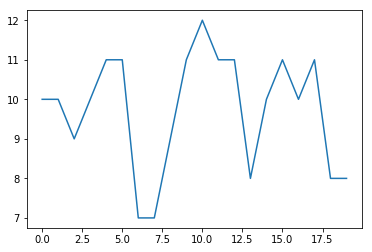

In [428]:
plt.plot(r_theta)
print(np.mean(r_theta))

In [429]:
R_mean_list = np.array(R_mean_list)
R_mean = np.mean(R_mean_list)
print(R_mean_list)
print(R_mean)

[9.47619048 9.65       9.65       9.45       9.5        9.2
 9.28571429 9.05       9.35       9.1        9.45       9.35
 9.65       9.61904762 9.55       9.5        9.4        9.38095238
 9.8        9.5        9.55       9.4        9.35       9.3
 9.4        9.6        9.75       9.55       9.65       9.85
 9.8        9.55       9.75       9.5        9.57142857 9.75
 9.7        9.65       9.45       9.4        9.6        9.6
 9.55       9.35       9.65       9.5        9.42857143 9.38095238
 9.65       9.45       9.6        9.6        9.45       9.45
 9.65       9.45       9.25       9.75       9.65       9.25
 9.42857143 9.75       9.65       9.6        9.75       9.75      ]
9.524567099567099


In [430]:
r_q_pow_ar = np.array(r_q_pow_list)
print(r_q_pow_ar.shape)
print(r_q_pow_ar)

(11, 66)
[[3.96010000e+04 3.72490000e+04 3.72490000e+04 3.57210000e+04
  3.61000000e+04 3.38560000e+04 3.80250000e+04 3.27610000e+04
  3.49690000e+04 3.31240000e+04 3.57210000e+04 3.49690000e+04
  3.72490000e+04 4.08040000e+04 3.64810000e+04 3.61000000e+04
  3.53440000e+04 3.88090000e+04 3.84160000e+04 3.61000000e+04
  3.64810000e+04 3.53440000e+04 3.49690000e+04 3.45960000e+04
  3.53440000e+04 3.68640000e+04 3.80250000e+04 3.64810000e+04
  3.72490000e+04 3.88090000e+04 3.84160000e+04 3.64810000e+04
  3.80250000e+04 3.61000000e+04 4.04010000e+04 3.80250000e+04
  3.76360000e+04 3.72490000e+04 3.57210000e+04 3.53440000e+04
  3.68640000e+04 3.68640000e+04 3.64810000e+04 3.49690000e+04
  3.72490000e+04 3.61000000e+04 3.92040000e+04 3.88090000e+04
  3.72490000e+04 3.57210000e+04 3.68640000e+04 3.68640000e+04
  3.57210000e+04 3.57210000e+04 3.72490000e+04 3.57210000e+04
  3.42250000e+04 3.80250000e+04 3.72490000e+04 3.42250000e+04
  3.92040000e+04 3.80250000e+04 3.72490000e+04 3.68640000e+04

In [431]:
r_q_pow_ave = np.zeros(lq)
print(r_q_pow_ave)

for i in range(lq):
    r_q_pow_ave[i]=np.mean(r_q_pow_ar[i])

print(r_q_pow_ave)
print(r_q_pow_ave.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3.67420303e+04 7.40314754e+01 1.30623079e+02 5.77339841e+01
 3.99953708e+01 2.25054747e+01 2.86663869e+01 1.61374735e+01
 1.77660440e+01 1.42238998e+01 1.49228720e+01]
(11,)


In [432]:
power_sp = r_q_pow_ave * 1/R_mean**2
print(power_sp)

[4.05016447e+02 8.16067182e-01 1.43989037e+00 6.36415922e-01
 4.40878820e-01 2.48083390e-01 3.15996641e-01 1.77887344e-01
 1.95839477e-01 1.56793550e-01 1.64498492e-01]


In [433]:
np.save(path_res+'power_sp'+name+'.npy', power_sp)

In [434]:
l_ave = np.load(path_res+'power_sp'+name+'.npy')
print(q)
print(np.shape(q))
print(np.shape(l_ave))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(11,)
(11,)


Text(0,0.5,'$<|r(q)|²>$')

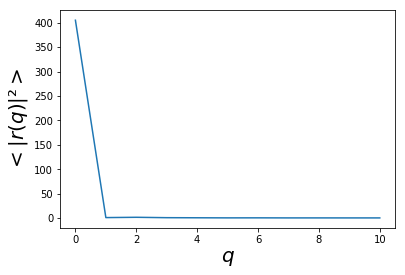

In [435]:
plt.plot(l_ave)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

Text(0,0.5,'$q⁴ <|r(q)|²>$')

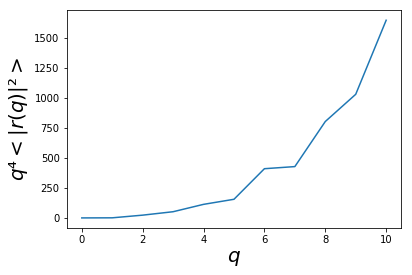

In [436]:
plt.plot(l_ave*q**4)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$q⁴ <|r(q)|²>$',fontsize=20)

In [437]:
qmin = 2
qmax = 6 # quelle valeur max ???
q2inv = 1/(q[qmin:qmax]**2-1)
print(q2inv)
varq = l_ave[qmin:qmax]

[0.33333333 0.125      0.06666667 0.04166667]


Text(0,0.5,'$<|r(q)|²>$')

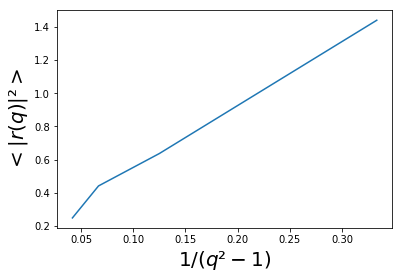

In [438]:
plt.plot(q2inv,varq)

plt.xlabel('$1/(q²-1)$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

[0.13287976 3.9419108 ]


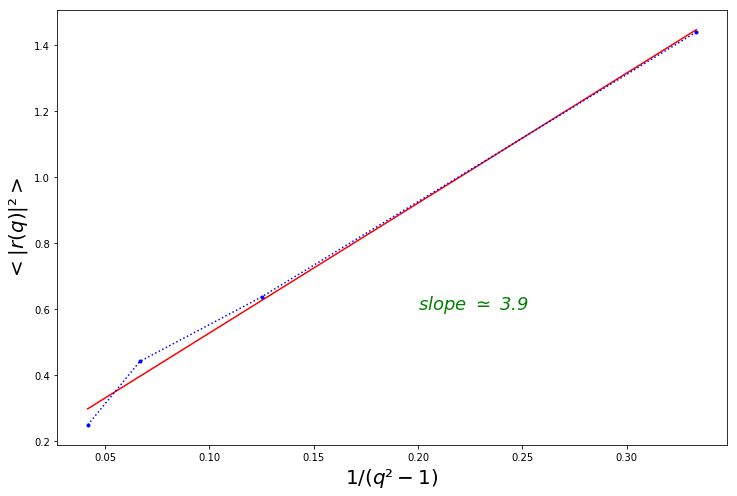

In [439]:
from numpy.polynomial import polynomial as P
pi = np.pi
fig, ax = plt.subplots(figsize=(12, 8))

pfit = P.polyfit(q2inv, varq, 1)
print(pfit)

ax.plot(q2inv, pfit[1]*q2inv+pfit[0], 'red')
ax.plot(q2inv, varq, ':b.')

plt.xlabel('$1/(q²-1)$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

plt.annotate('slope $\simeq$ %.1f ' % (pfit[1]), color='g', fontsize=18, style='italic', xy=(0.2,0.6), xytext=(0.2,0.6))

params = f'_r{nb_r}_theta{nb_theta}_stack{max_frame_stack}_tmes_{tmes}_qmax{qmax}'
plt.savefig(path_res+'linetension'+name+params+'.pdf', format='pdf',bbox_inches='tight')

In [360]:
4*10**(-21)/pi/10**(-8)/4.1

3.105462304232104e-14